# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

In [ ]:
from importlib import reload
# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2

In [ ]:
# import NN architectures for speech recognition
import models as M
# import function for training acoustic model
import train_utils as T

import utils as U

import data_generator as DG

print()
# U.config_GPU(gpu_memory_fraction=0.4)
U.config_GPU(allow_growth = True)

from keras.optimizers import SGD

#### Audio Data Generator

In [ ]:
def reload_all():
    reload(U)
    reload(DG)
    reload(M)
    reload(T)

audio_gen_mfcc = None
audio_gen_spec = None
audio_gen_raw  = None

def init_gen(spectrogram=True, raw=False):
    print("Initializing Generator for ", 
          "Raw" if raw else
          ("MFCC" if not spectrogram else "Spectrogram"))
    audio_gen = DG.AudioGeneratorCached(spectrogram=spectrogram, raw=raw, minibatch_size=32)
    audio_gen.load_train_data('train_corpus.json')
    audio_gen.load_validation_data('valid_corpus.json')
    return audio_gen

def init_gen_var(spectrogram=True, raw=False):
    global audio_gen_mfcc
    global audio_gen_spec
    global audio_gen_raw
    if raw:
        if not audio_gen_raw:
            audio_gen_raw = init_gen(raw=True)
    elif spectrogram:
        if not audio_gen_spec:
            audio_gen_spec = init_gen(spectrogram=True)
    else:
        if not audio_gen_mfcc:
            audio_gen_mfcc = init_gen(spectrogram=False)

def get_gen(spectrogram=True, raw=False):
    init_gen_var(spectrogram, raw)
    return audio_gen_raw if raw else (audio_gen_spec if spectrogram else audio_gen_mfcc)
        
                                      
model_names_to_compare = []

def train_model(model_builder, *args, spectrogram=True, raw=False, mfcc_concat=False, **kwargs):
    reload(M)
    reload(T)
    global audio_gen_mfcc
    global audio_gen_spec
    global audio_gen_raw
    init_gen_var(spectrogram)
    name = T.train_model(audio_gen_raw if raw else (audio_gen_spec if spectrogram else audio_gen_mfcc), model_builder, *args, **kwargs)
    model_names_to_compare.append(name)
    

In [ ]:
def plot_comparison(model_names=None, *args, **kwargs):
    reload(T)
    
    if model_names is None:
        names = model_names_to_compare
        print_model_names(names)
    else:
        names = model_names
    pickles = []
    for name in names:
        pickles.append("results/" + name + ".pickle")
    T.plot_comparison(pickles=pickles, *args, **kwargs)
    
def print_model_names(model_names=None):
    print_list_of_strings(model_names if model_names is not None else model_names_to_compare)
    
    
def print_list_of_strings(list_of_strings):
    print("[", end="")
    first = True
    for name in list_of_strings:
        if not first:
            print(",")
            print(" ", end="")
        else:
            first = False
        print("\'"+name+"\'", end="")
    print("]")

In [5]:
reload(DG)
DG.test_gen()

(1, 229, 161) (1, 27) a great rascal put in north
(1, 229, 161) (1, 38) mister verloc was fully responsive now
(1, 230, 161) (1, 38) i get nothing but misery out of either
(1, 230, 161) (1, 28) where are they asked the boy
(1, 231, 161) (1, 26) alexander exclaimed mildly
(1, 231, 161) (1, 27) tad is an experienced rider
(1, 231, 161) (1, 24) hers has been prodigious
(1, 231, 161) (1, 13) italian rusks
(1, 232, 161) (1, 37) of course it ain't said missus bozzle
(1, 232, 161) (1, 22) he's a great scientist
(1, 233, 161) (1, 19) good by dear randal
(1, 233, 161) (1, 26) humph grunted curley adams
(1, 233, 161) (1, 30) here comes the snapping turtle
(1, 234, 161) (1, 34) a little attack of nerves possibly
(1, 234, 161) (1, 43) you'll all be over if you don't have a care
(1, 235, 161) (1, 23) fried bread for borders
(1, 235, 161) (1, 28) that's macklewain's business
(1, 236, 161) (1, 29) at least that is what we hope
(1, 236, 161) (1, 25) they persuaded eloquently
(1, 236, 161) (1, 34) the 

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [55]:
# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = DG.vis_train_features(mfcc_classes=26)

There are 2023 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

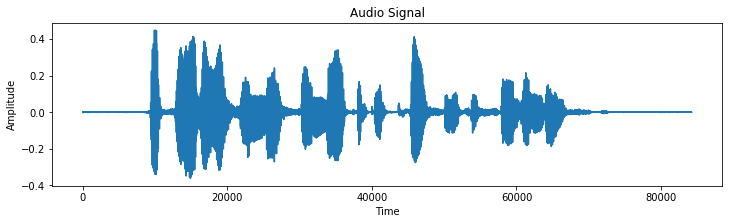

**Shape of Audio Signal** : (84231,)

**Transcript** : her father is a most remarkable person to say the least

In [56]:
from IPython.display import Markdown, display
from IPython.display import Audio
%matplotlib inline

# plot audio signal
DG.plot_raw_audio(vis_raw_audio)
# print length of audio signal

display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

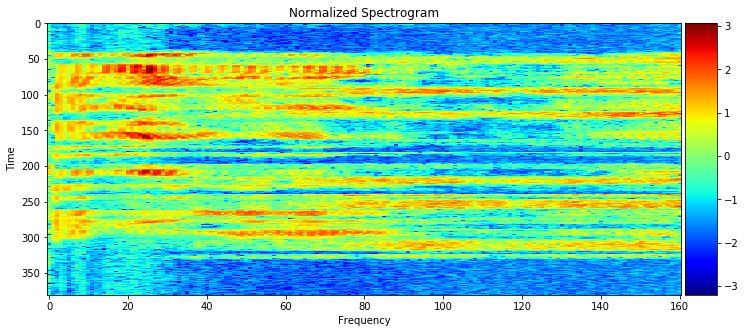

**Shape of Spectrogram** : (381, 161)

In [9]:
# plot normalized spectrogram
DG.plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

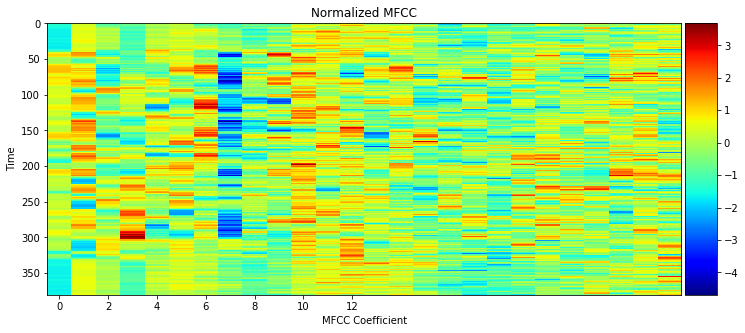

**Shape of MFCC** : (381, 26)

In [16]:
# plot normalized MFCC
DG.plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 26)          0         
_________________________________________________________________
rnn1 (SimpleRNN)             (None, None, 200)         45400     
_________________________________________________________________
softmax (Activation)         (None, None, 200)         0         
Total params: 45,400
Trainable params: 45,400
Non-trainable params: 0
_________________________________________________________________


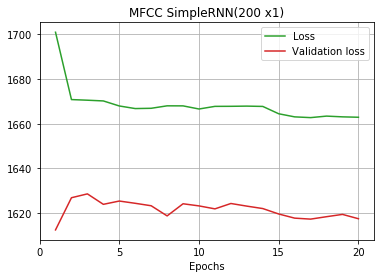

In [4]:
train_model(M.RNNModel(bd_merge=None, rnn_type = M.RNNType.SimpleRNN, time_distributed_dense=False), 
            spectrogram=False, 
            epochs=20, loss_limit=None) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn1 (SimpleRNN)             (None, None, 200)         72400     
_________________________________________________________________
softmax (Activation)         (None, None, 200)         0         
Total params: 72,400
Trainable params: 72,400
Non-trainable params: 0
_________________________________________________________________


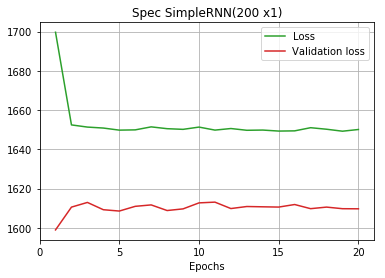

In [5]:
train_model(M.RNNModel(bd_merge=None, rnn_type = M.RNNType.SimpleRNN, time_distributed_dense=False), 
            epochs=20, loss_limit=None) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn1 (CuDNNLSTM)             (None, None, 200)         290400    
_________________________________________________________________
softmax (Activation)         (None, None, 200)         0         
Total params: 290,400
Trainable params: 290,400
Non-trainable params: 0
_________________________________________________________________


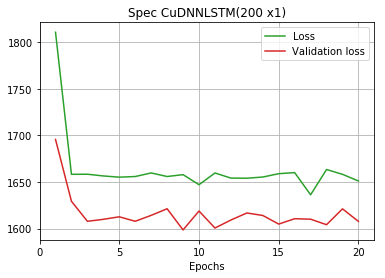

In [6]:
train_model(M.RNNModel(bd_merge=None, time_distributed_dense=False), 
            epochs=20, loss_limit=None) 

### Observations:
- Clearly, a SimpleRNN or LSTM models without Time-Distributed Dense layers are inadequate

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn1 (CuDNNLSTM)             (None, None, 200)         290400    
_________________________________________________________________
relu (Activation)            (None, None, 200)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

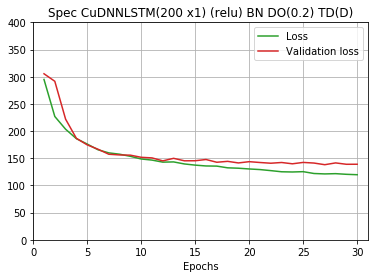

In [7]:
train_model(M.RNNModel(bd_merge=None, rnn_type=RNNType.LSTM))

### Observations:
- Addition of Time-Distributed Dense drastically improves performance

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 200)         800       
_________________________________________________________________
rnn1 (CuDNNLSTM)             (None, None, 200)         321600    
_________________________________________________________________
relu (Activation)            (None, None, 200)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 200)         800       
__________

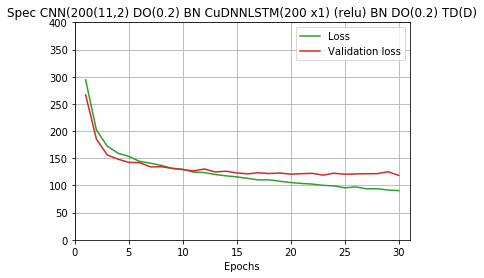

In [11]:
train_model(model_builder=M.RNNModel(cnn_config=M.CNNConfig(), bd_merge=None, rnn_type=RNNType.LSTM))

<b><span style="color:magenta">TODO: Try to plot comparison with and without CNN</span></b>

### Observations:
- Addition of CNN Layer before the RNN part improves performance considerably

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn1 (CuDNNLSTM)             (None, None, 200)         290400    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
rnn2 (CuDNNLSTM)             (None, None, 200)         321600    
_________________________________________________________________
relu (Activation)            (None, None, 200)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 200)         800       
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 200)         0         
__________

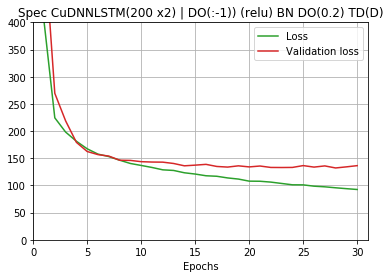

In [12]:
train_model(M.RNNModel(bd_merge=None, rnn_type=RNNType.LSTM, rnn_layers=2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn1 (CuDNNLSTM)             (None, None, 200)         290400    
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
rnn2 (CuDNNLSTM)             (None, None, 200)         321600    
_________________________________________________________________
dropout_23 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
rnn3 (CuDNNLSTM)             (None, None, 200)         321600    
_________________________________________________________________
relu (Activation)            (None, None, 200)         0         
__________

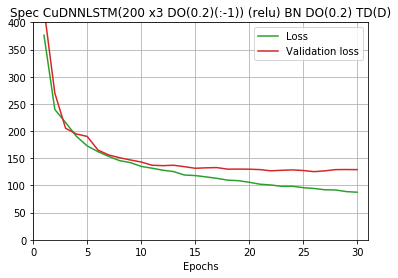

In [19]:
train_model(M.RNNModel(bd_merge=None, rnn_type=RNNType.LSTM, rnn_layers=3))

<b><span style="color:magenta">TODO: Try to plot comparison for 1..3 of RNNlayers</span></b>

### Observations:
- Addition more RNN layers (without CNN layer) improves performance 

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 400)         580800    
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNLSTM)             (None, None, 200)         481600    
_________________________________________________________________
relu (Activation)            (None, None, 200)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, None, 200)         800       
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 200)         0         
__________

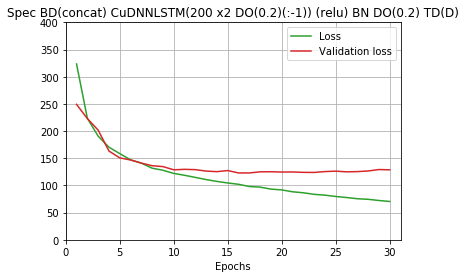

In [20]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, rnn_layers=2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 200)         580800    
_________________________________________________________________
dropout_27 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
rnn2 (CuDNNLSTM)             (None, None, 200)         321600    
_________________________________________________________________
relu (Activation)            (None, None, 200)         0         
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 200)         800       
_________________________________________________________________
dropout_28 (Dropout)         (None, None, 200)         0         
__________

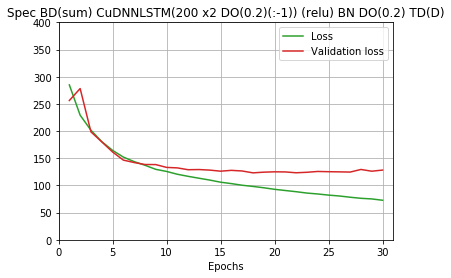

In [21]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.sum, rnn_layers=2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 200)         580800    
_________________________________________________________________
dropout_29 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
rnn2 (CuDNNLSTM)             (None, None, 200)         321600    
_________________________________________________________________
relu (Activation)            (None, None, 200)         0         
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 200)         800       
_________________________________________________________________
dropout_30 (Dropout)         (None, None, 200)         0         
__________

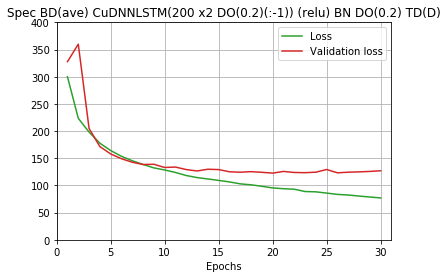

In [22]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.ave, rnn_layers=2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 200)         580800    
_________________________________________________________________
dropout_31 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
rnn2 (CuDNNLSTM)             (None, None, 200)         321600    
_________________________________________________________________
relu (Activation)            (None, None, 200)         0         
_________________________________________________________________
batch_normalization_19 (Batc (None, None, 200)         800       
_________________________________________________________________
dropout_32 (Dropout)         (None, None, 200)         0         
__________

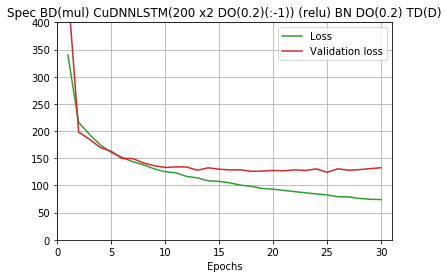

In [23]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.mul, rnn_layers=2))

<b><span style="color:magenta">TODO: Try to plot comparison for all merge modes and without BD</span></b>

### Observations:
<b><span style="color:magenta">
    Bidirectional models perform better than unidirectional one
</span></b>
    - Among the merge modes, multiplication probably shows the worst performance with the remaining three showing roughly similar performance. The concat mode might reach its best slightly sooner. 

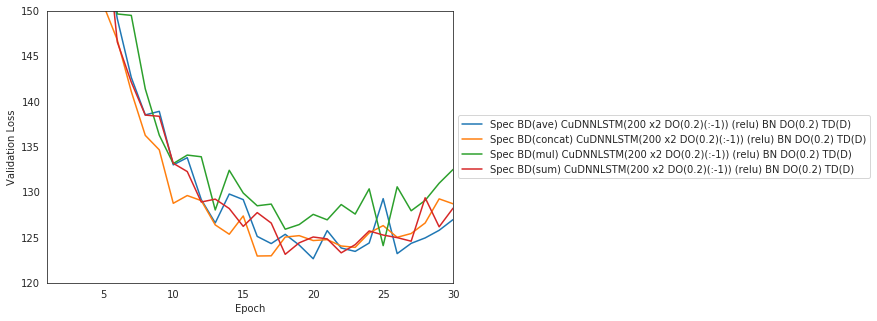

In [48]:
T.plot_comparison(pickles=[           'results/Spec CuDNNLSTM(200 x2) DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).picklee',
                              'results/Spec BD(ave) CuDNNLSTM(200 x2 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle',
                           'results/Spec BD(concat) CuDNNLSTM(200 x2 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle',
                              'results/Spec BD(mul) CuDNNLSTM(200 x2 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle',
                              'results/Spec BD(sum) CuDNNLSTM(200 x2 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle'], 
                  min_epoch=1, min_loss=120, max_loss=150)

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

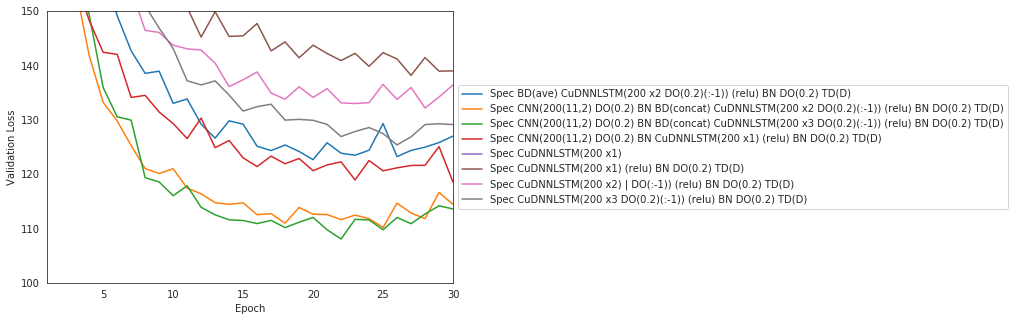

In [51]:
T.plot_comparison(
    pickles=[
        'results/Spec BD(ave) CuDNNLSTM(200 x2 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle',
        'results/Spec CNN(200(11,2) DO(0.2) BN BD(concat) CuDNNLSTM(200 x2 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle',
        'results/Spec CNN(200(11,2) DO(0.2) BN BD(concat) CuDNNLSTM(200 x3 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle',
        'results/Spec CNN(200(11,2) DO(0.2) BN CuDNNLSTM(200 x1) (relu) BN DO(0.2) TD(D).pickle',
        'results/Spec CuDNNLSTM(200 x1).pickle',
        'results/Spec CuDNNLSTM(200 x1) (relu) BN DO(0.2) TD(D).pickle',
        'results/Spec CuDNNLSTM(200 x2) DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle',
        'results/Spec CuDNNLSTM(200 x3 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle'], 
                  min_epoch=1, min_loss=100, max_loss=150)

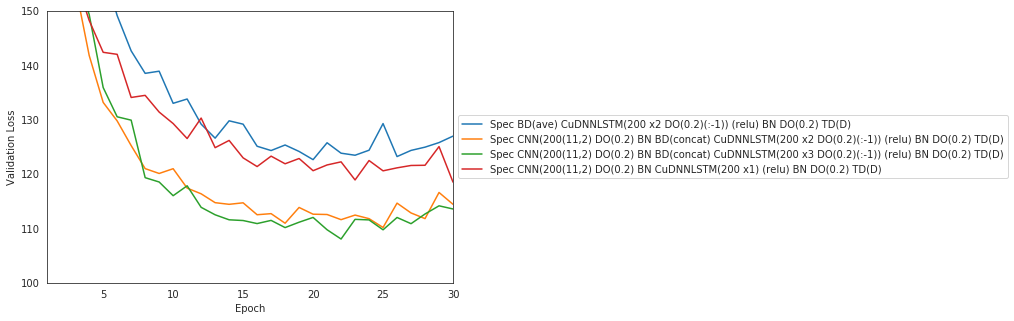

In [53]:
T.plot_comparison(
    pickles=[
        'results/Spec BD(ave) CuDNNLSTM(200 x2 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle',
        'results/Spec CNN(200(11,2) DO(0.2) BN CuDNNLSTM(200 x1) (relu) BN DO(0.2) TD(D).pickle',
        'results/Spec CNN(200(11,2) DO(0.2) BN BD(concat) CuDNNLSTM(200 x2 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle',
        'results/Spec CNN(200(11,2) DO(0.2) BN BD(concat) CuDNNLSTM(200 x3 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle'],
                  min_epoch=1, min_loss=100, max_loss=150)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
dropout_33 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
batch_normalization_20 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 400)         643200    
_________________________________________________________________
dropout_34 (Dropout)         (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNLSTM)             (None, None, 200)         481600    
__________

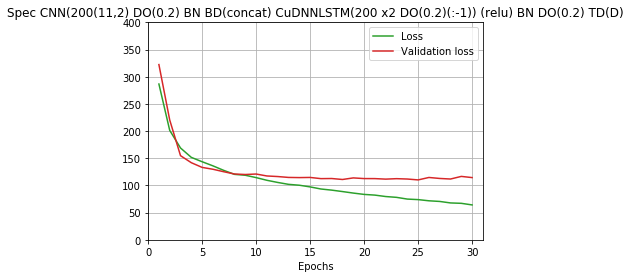

In [24]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_0, rnn_layers=2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
dropout_36 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
batch_normalization_22 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 400)         643200    
_________________________________________________________________
dropout_37 (Dropout)         (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNLSTM)             (None, None, 200)         481600    
__________

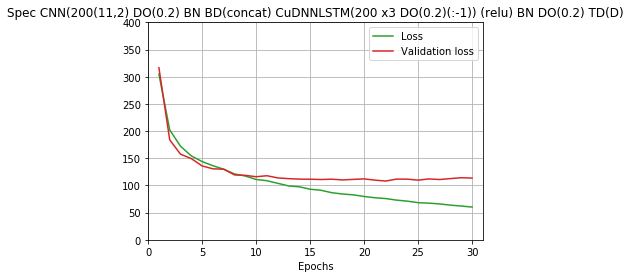

In [25]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_0, rnn_layers=3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_141 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_91 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
dropout_142 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_92 (Batc (None, None, 200)         800       
__________

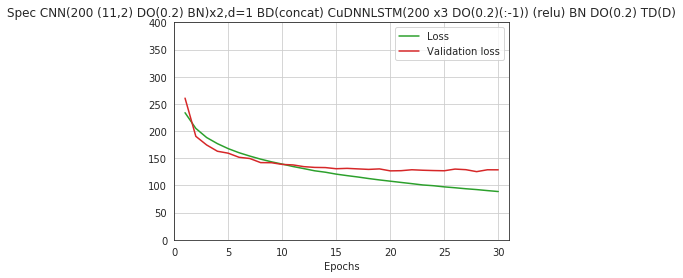

In [77]:
cnn_config_2=M.CNNConfig(filters=200, kernel_size=11, conv_stride=2, conv_border_mode='valid', cnn_layers=2)
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_2, rnn_layers=3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_132 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_84 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
dropout_133 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_85 (Batc (None, None, 200)         800       
__________

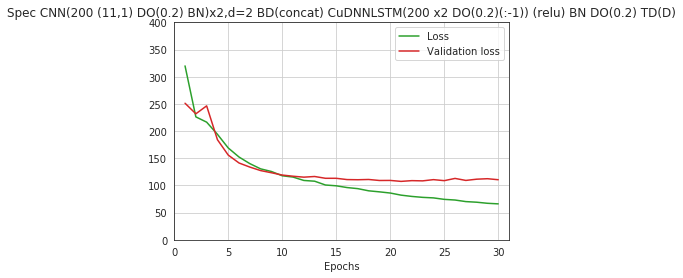

In [75]:
cnn_config_2d=M.CNNConfig(filters=200, kernel_size=11, conv_stride=1, conv_border_mode='valid', cnn_layers=2, dilation=2)
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_2d, rnn_layers=2))

In [14]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(filters=200, kernel_size=11, conv_stride=1, conv_border_mode='valid', 
                                   cnn_layers=2, dilation=2, cnn_dense=True),
                       bd_merge=M.BidirectionalMerge.concat, 
                       rnn_layers=2))

KeyboardInterrupt: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_146 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_94 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
dropout_147 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_95 (Batc (None, None, 200)         800       
__________

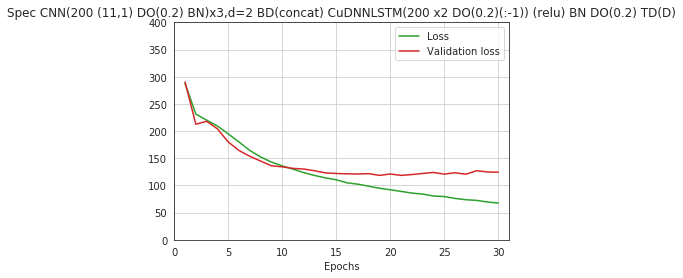

In [79]:
cnn_config_3d=M.CNNConfig(filters=200, kernel_size=11, conv_stride=1, conv_border_mode='valid', cnn_layers=3, dilation=2)
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_3d, rnn_layers=2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_240 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_147 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
dropout_241 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_148 (Bat (None, None, 200)         800       
__________

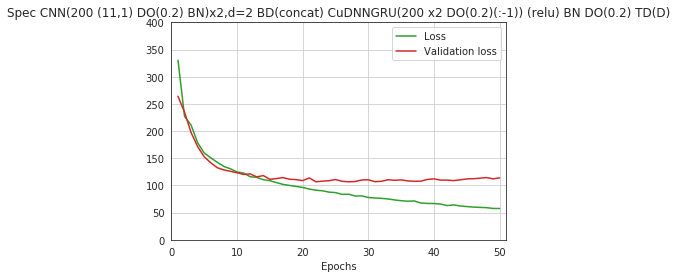

In [107]:
cnn_config_2d=M.CNNConfig(filters=200, kernel_size=11, conv_stride=1, conv_border_mode='valid', cnn_layers=2, dilation=2)
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_2d, 
                       rnn_type=M.RNNType.GRU, rnn_layers=2), epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 200)    354400      the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, None, 200)    800         conv1d1[0][0]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, None, 361)    0           the_input[0][0]                  
                                                                 batch_normalization_40[0][0]     
__________

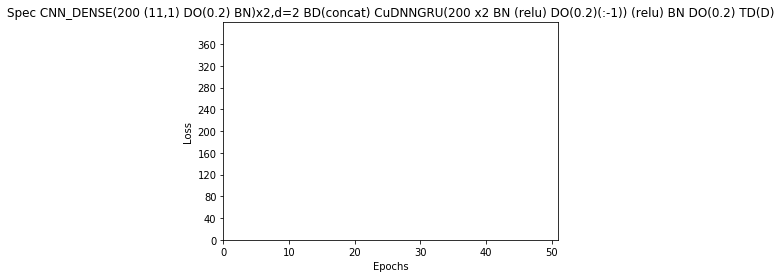

In [13]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(filters=200, kernel_size=11, conv_stride=1, conv_border_mode='valid', 
                                              cnn_layers=2, dilation=2, cnn_dense=True), 
                       bd_merge=M.BidirectionalMerge.concat, 
                       rnn_type=M.RNNType.GRU, rnn_layers=2), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_236 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_145 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_51 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
dropout_237 (Dropout)        (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNGRU)              (None, None, 200)         361200    
__________

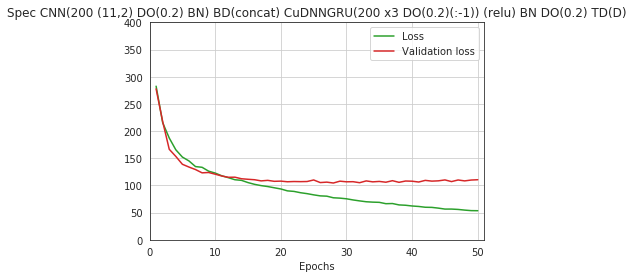

In [106]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_0, 
                       rnn_type=M.RNNType.GRU, rnn_layers=3), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_231 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_143 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_50 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
dropout_232 (Dropout)        (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNGRU)              (None, None, 200)         361200    
__________

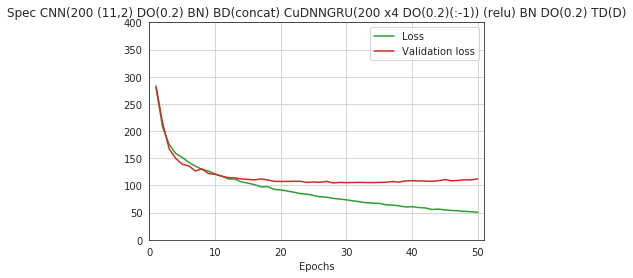

In [105]:
train_model(M.RNNModel(cnn_config=cnn_config_0, 
                       rnn_type=M.RNNType.GRU, rnn_layers=4), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_310 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
rnn1 (CuDNNGRU)              (None, None, 200)         241200    
_________________________________________________________________
dropout_311 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluR0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
rnn2 (CuDNNGRU)              (None, None, 200)         241200    
__________

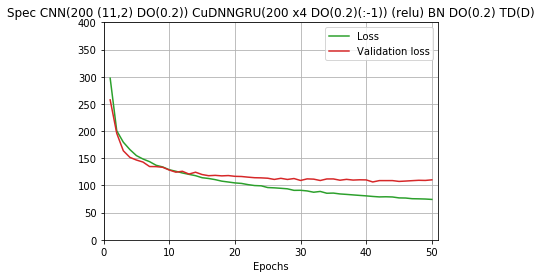

In [74]:
train_model(M.RNNModel(cnn_config=cnn_config_0, 
                       rnn_type=M.RNNType.GRU, rnn_layers=4), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_243 (Bat (None, None, 200)         800       
_________________________________________________________________
dropout_315 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
rnn1 (CuDNNGRU)              (None, None, 200)         241200    
_________________________________________________________________
dropout_316 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluR0 (Activation)          (None, None, 200)         0         
__________

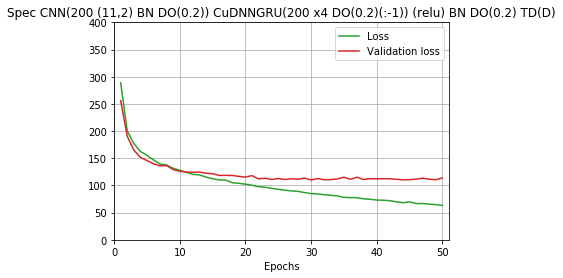

In [75]:
train_model(M.RNNModel(cnn_config=cnn_config_0, 
                       rnn_type=M.RNNType.GRU, rnn_layers=4), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_245 (Bat (None, None, 200)         800       
_________________________________________________________________
rnn1 (CuDNNGRU)              (None, None, 200)         241200    
_________________________________________________________________
dropout_320 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluR0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
rnn2 (CuDNNGRU)              (None, None, 200)         241200    
__________

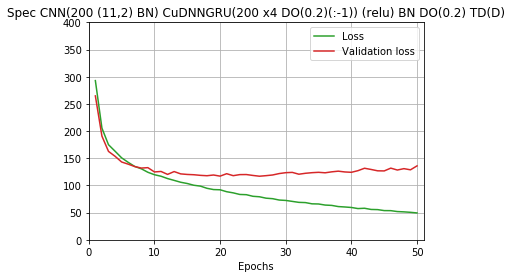

In [76]:
train_model(M.RNNModel(cnn_config=cnn_config_0, 
                       rnn_type=M.RNNType.GRU, rnn_layers=4), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_272 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_225 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_29 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
dropout_273 (Dropout)        (None, None, 400)         0         
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

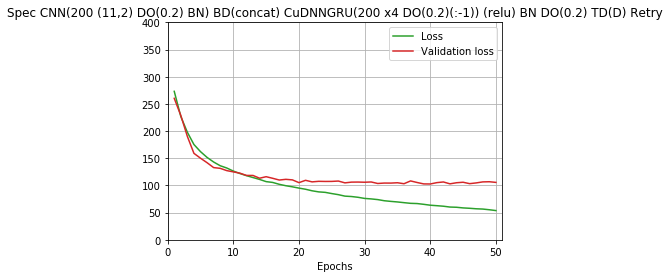

In [67]:
train_model(M.RNNModel(cnn_config=cnn_config_0, 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=4, name_suffix="Retry"), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_47 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
batch_normalization_63 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_13 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_64 (Batc (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

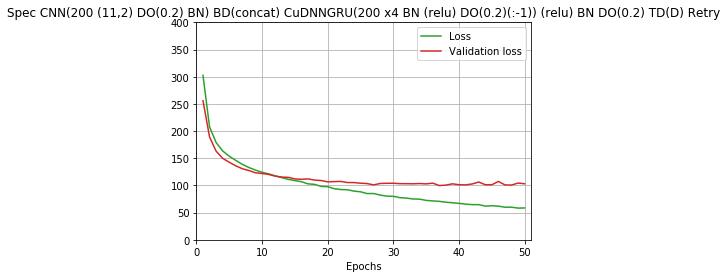

In [22]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=4, name_suffix="Retry"), epochs=50)

### Comparing Dropout, Batch Normalization and Activation Configuration of the CNN layer

In [13]:
model_names_to_compare = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
relu (Activation)            (None, None, 400)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 400)         1600      
__________

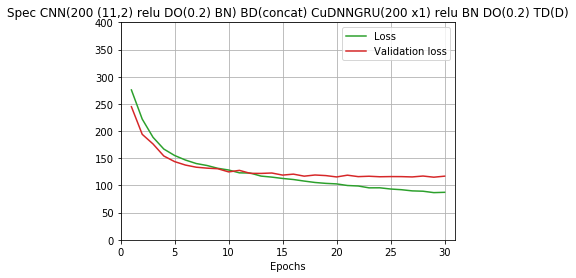

In [14]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 200)         800       
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
relu (Activation)            (None, None, 400)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 400)         1600      
__________

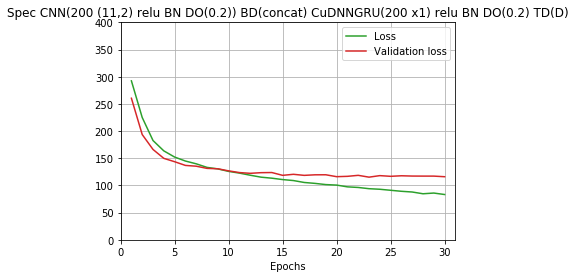

In [16]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_do_bn_order=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
relu (Activation)            (None, None, 400)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 400)         1600      
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 400)         0         
__________

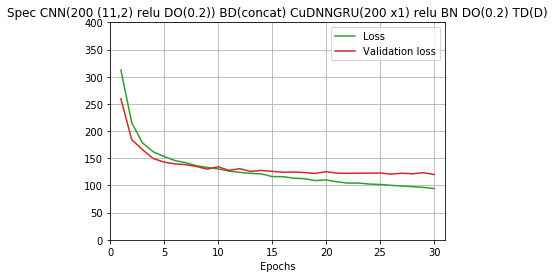

In [18]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_bn=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
relu (Activation)            (None, None, 400)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 400)         1600      
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 400)         0         
__________

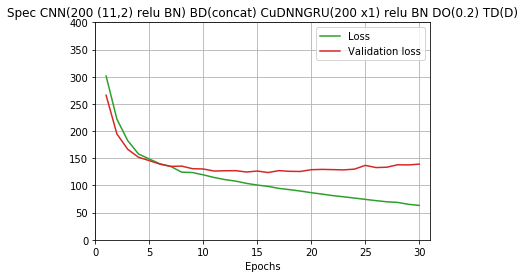

In [19]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
relu (Activation)            (None, None, 400)         0         
__________

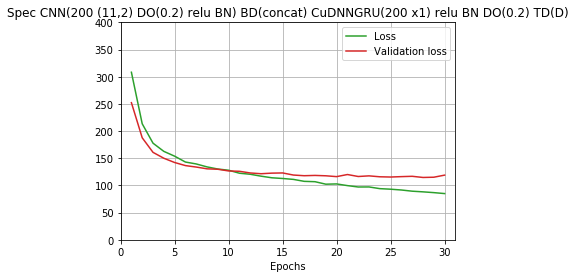

In [20]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
relu (Activation)            (None, None, 400)         0         
_________________________________________________________________
batch_normalization_14 (Batc (None, None, 400)         1600      
__________

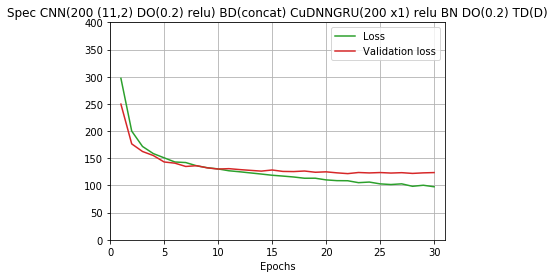

In [21]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_activation_before_bn_do=False, cnn_bn=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_15 (Batc (None, None, 200)         800       
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
relu (Activation)            (None, None, 400)         0         
__________

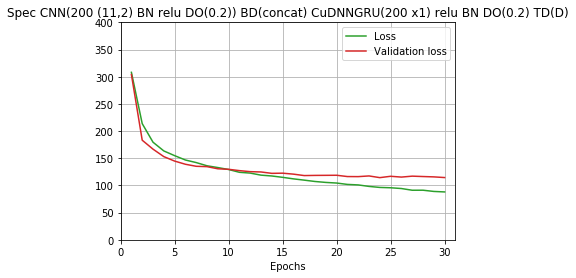

In [22]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_activation_before_bn_do=False, 
                                              cnn_do_bn_order=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 200)         800       
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
relu (Activation)            (None, None, 400)         0         
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 400)         1600      
__________

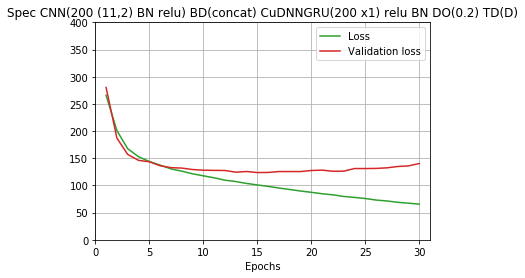

In [23]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_activation_before_bn_do=False, 
                                              cnn_do_bn_order=False, cnn_dropout_rate=0),
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=30)

['Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu BN DO(0.2)) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2)) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu BN) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) DO(0.2) relu BN) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) DO(0.2) relu) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) BN relu DO(0.2)) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) BN relu) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)']


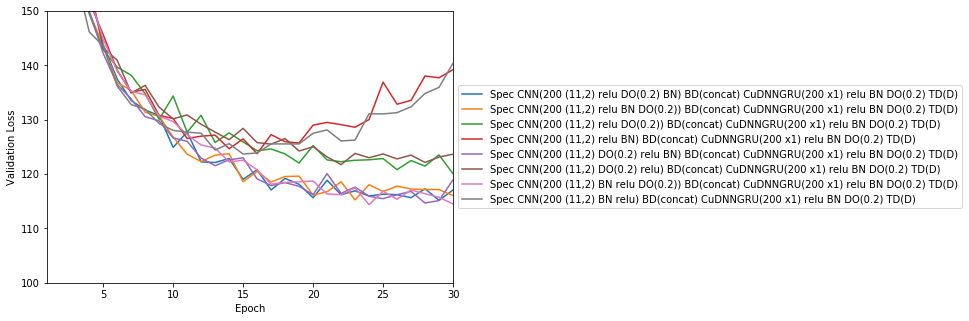

In [37]:
plot_comparison(model_names=\
['Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu BN DO(0.2)) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2)) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu BN) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) DO(0.2) relu BN) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) DO(0.2) relu) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) BN relu DO(0.2)) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) BN relu) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)'],                
                max_loss=150, min_loss=100)

### Observations: ...

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_142 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_161 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
dropout_143 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_162 (Bat (None, None, 200)         800       
__________

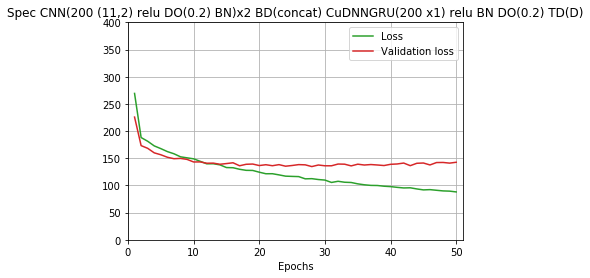

In [113]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_layers=2), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_173 (Bat (None, None, 200)         800       
_________________________________________________________________
dropout_154 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
batch_normalization_174 (Bat (None, None, 200)         800       
_________________________________________________________________
dropout_155 (Dropout)        (None, None, 200)         0         
__________

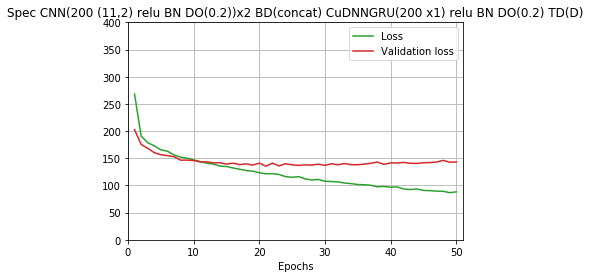

In [118]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_do_bn_order=False, cnn_layers=2), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_157 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_176 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
dropout_158 (Dropout)        (None, None, 200)         0         
__________

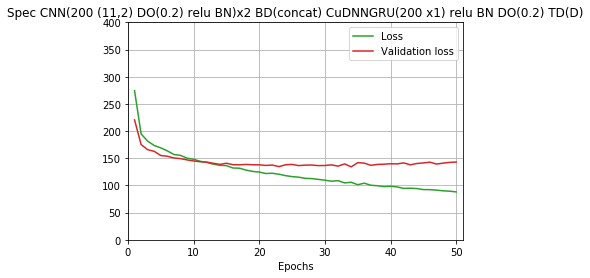

In [119]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_activation_before_bn_do=False, cnn_layers=2), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_179 (Bat (None, None, 200)         800       
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
dropout_160 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
batch_normalization_180 (Bat (None, None, 200)         800       
__________

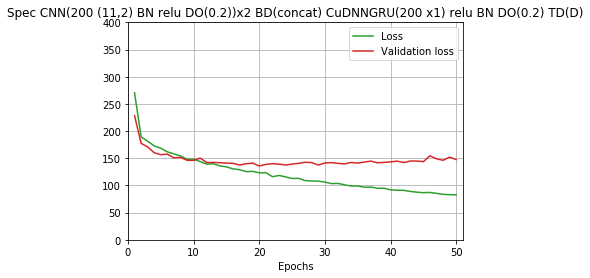

In [120]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_activation_before_bn_do=False, 
                                              cnn_do_bn_order=False, cnn_layers=2), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

[' Spec CNN(200 (11,2) relu DO(0.2) BN)x2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D) ',
 ' Spec CNN(200 (11,2) relu BN DO(0.2))x2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D) ',
 ' Spec CNN(200 (11,2) DO(0.2) relu BN)x2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D) ',
 ' Spec CNN(200 (11,2) BN relu DO(0.2))x2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D) ']


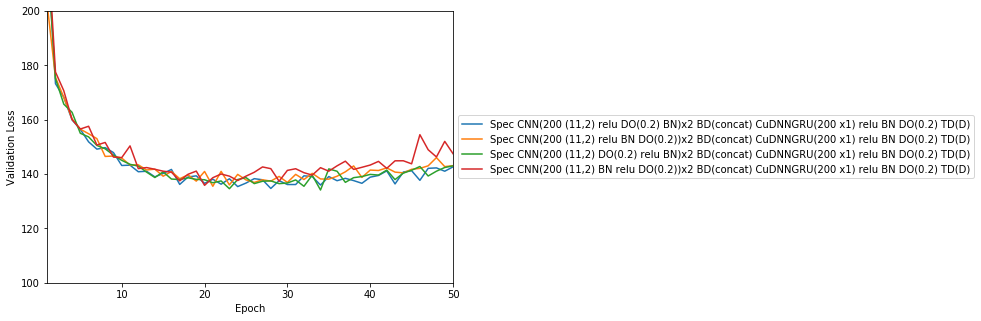

In [164]:
plot_comparison(max_loss=200, min_loss=100)

### Comparing...

In [44]:
model_names_to_compare = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         161200    
_________________________________________________________________
dropout_31 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_31 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         200200    
_________________________________________________________________
dropout_32 (Dropout)         (None, None, 200)         0         
__________

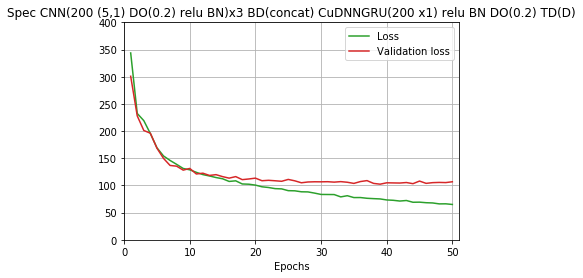

In [45]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=5, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=3,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         161200    
_________________________________________________________________
batch_normalization_39 (Batc (None, None, 200)         800       
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
dropout_39 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         200200    
_________________________________________________________________
batch_normalization_40 (Batc (None, None, 200)         800       
__________

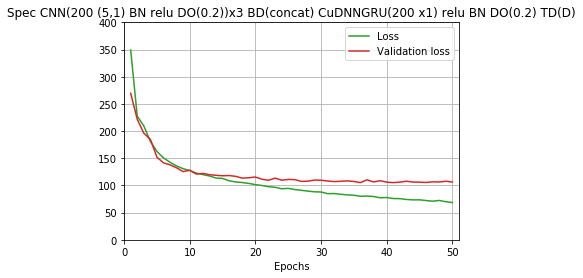

In [48]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=5, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=3,
                                              cnn_activation_before_bn_do=False, 
                                              cnn_do_bn_order=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         161200    
_________________________________________________________________
dropout_35 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
batch_normalization_35 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         200200    
_________________________________________________________________
dropout_36 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
batch_normalization_36 (Batc (None, None, 200)         800       
__________

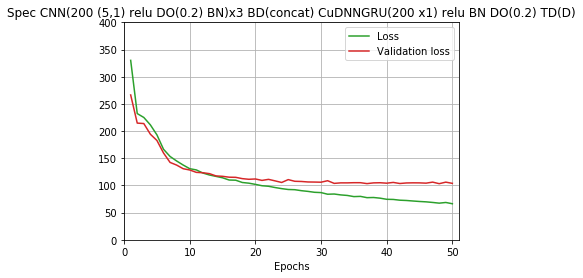

In [46]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=5, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=3), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

['Spec CNN(200 (5,1) DO(0.2) relu BN)x3 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (5,1) relu DO(0.2) BN)x3 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (5,1) BN relu DO(0.2))x3 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)']


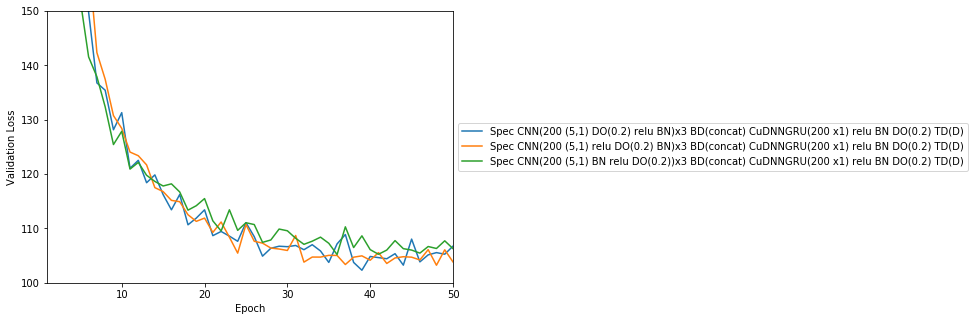

In [50]:
plot_comparison(max_loss=150, min_loss=100)

### Comparing...

In [55]:
model_names_to_compare = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         161200    
_________________________________________________________________
dropout_66 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_66 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         200200    
_________________________________________________________________
dropout_67 (Dropout)         (None, None, 200)         0         
__________

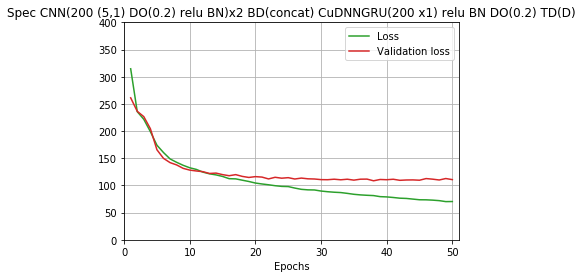

In [56]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=5, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         161200    
_________________________________________________________________
dropout_69 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_69 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         200200    
_________________________________________________________________
dropout_70 (Dropout)         (None, None, 200)         0         
__________

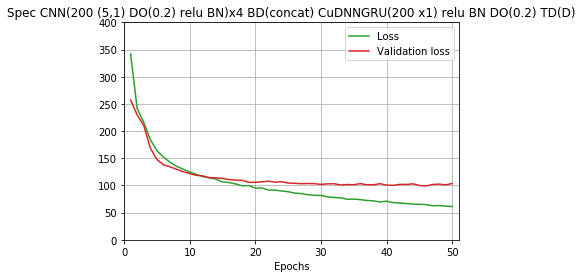

In [57]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=5, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=4,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_74 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_74 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_75 (Dropout)         (None, None, 200)         0         
__________

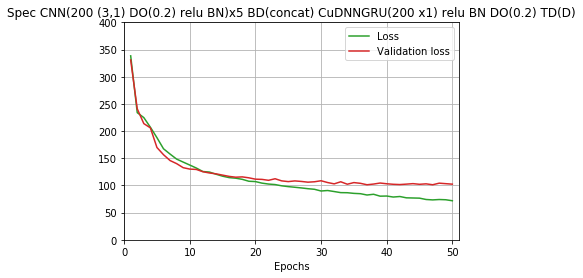

In [58]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=5,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_80 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_80 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_81 (Dropout)         (None, None, 200)         0         
__________

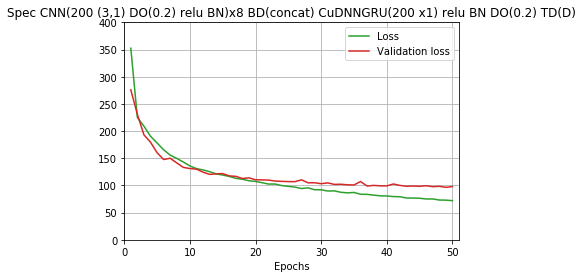

In [59]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=8,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_43 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_43 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_44 (Dropout)         (None, None, 200)         0         
__________

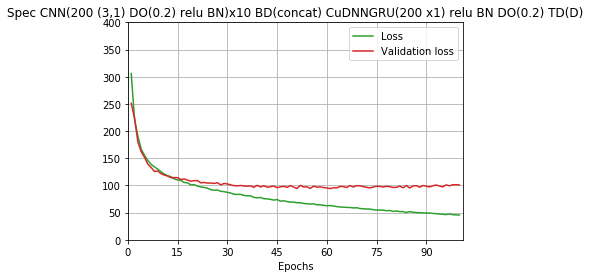

In [36]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=10,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_54 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_54 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_55 (Dropout)         (None, None, 200)         0         
__________

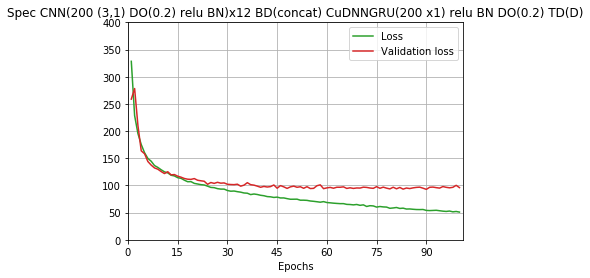

In [37]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_215 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_215 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_216 (Dropout)        (None, None, 200)         0         
__________

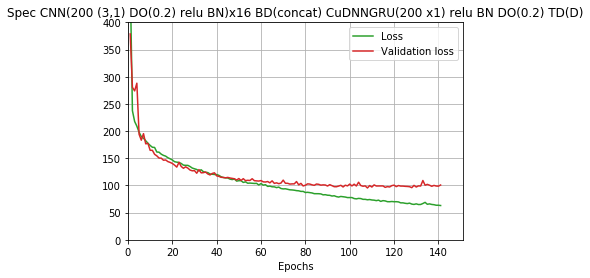

In [94]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=16,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=150)

['Spec CNN(200 (5,1) DO(0.2) relu BN)x2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (5,1) DO(0.2) relu BN)x4 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x5 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x8 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x10 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x16 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)']


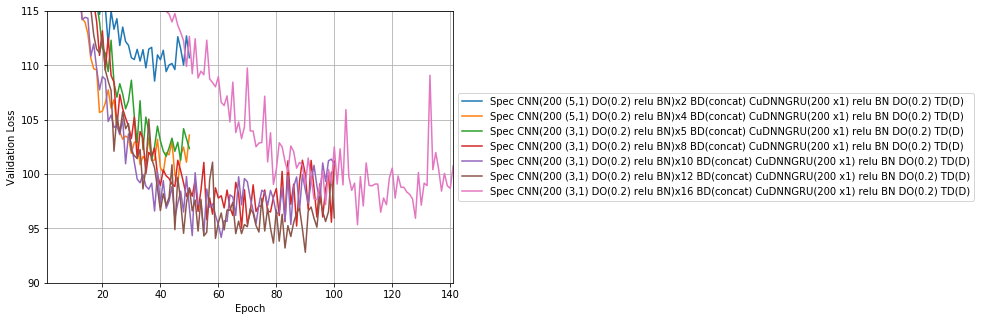

In [42]:
plot_comparison(model_names=\
['Spec CNN(200 (5,1) DO(0.2) relu BN)x2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (5,1) DO(0.2) relu BN)x4 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x5 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x8 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x10 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x16 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)']                
                max_loss=115, min_loss=90)

### Comparing

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_54 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_54 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_55 (Dropout)         (None, None, 200)         0         
__________

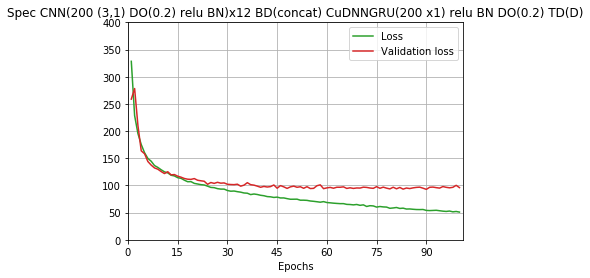

In [37]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

In [95]:
# M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
#                                               cnn_layers=12, cnn_dense=True, filters=90), 
#                                  rnn_layers=0).model(161,29);
M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dense=True, filters=90), 
                                 rnn_layers=0).model_name()


'CNN_DENSE(90 (3,1) DO(0.2) relu BN)x12  BN relu DO(0.2) TD(D)'

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 76)     36784       the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_327 (BatchN (None, None, 76)     304         conv1d1[0][0]                    
__________________________________________________________________________________________________
reluC0 (Activation)             (None, None, 76)     0           batch_normalization_327[0][0]    
__________________________________________________________________________________________________
dropout_33

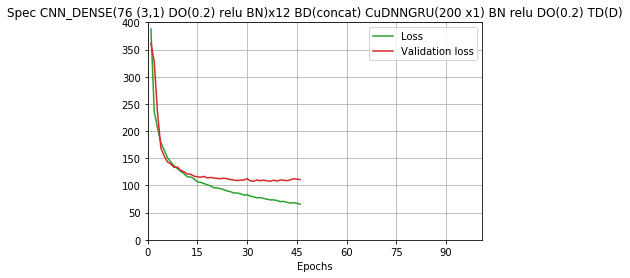

In [80]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dense=True, filters=76), 
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

In [100]:
model_names_to_compare=[]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 76)     36784       the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_455 (BatchN (None, None, 76)     304         conv1d1[0][0]                    
__________________________________________________________________________________________________
reluC0 (Activation)             (None, None, 76)     0           batch_normalization_455[0][0]    
__________________________________________________________________________________________________
dropout_45

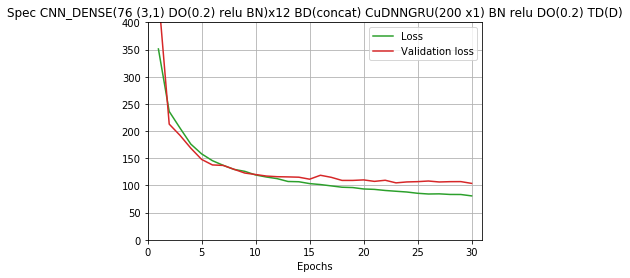

In [101]:
from keras.optimizers import SGD
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dense=True, filters=76), 
                       rnn_layers=1), 
                       optimizer=SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
                       epochs=30)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 76)     36784       the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, None, 76)     304         conv1d1[0][0]                    
__________________________________________________________________________________________________
reluC0 (Activation)             (None, None, 76)     0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
dropout_45

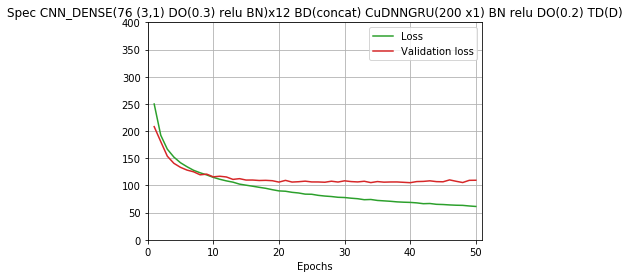

In [10]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dense=True, filters=76, cnn_dropout_rate=0.3), 
                       rnn_layers=1), 
                       optimizer=SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
                       epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 150)    72600       the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_481 (BatchN (None, None, 150)    600         conv1d1[0][0]                    
__________________________________________________________________________________________________
reluC0 (Activation)             (None, None, 150)    0           batch_normalization_481[0][0]    
__________________________________________________________________________________________________
dropout_48

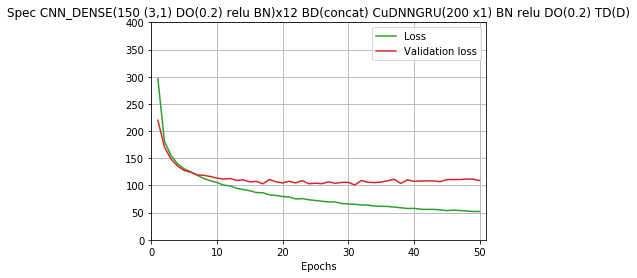

In [103]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dense=True, filters=150), 
                       rnn_layers=1), 
                       optimizer=SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
                       epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 76)     36784       the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 76)     304         conv1d1[0][0]                    
__________________________________________________________________________________________________
reluC0 (Activation)             (None, None, 76)     0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

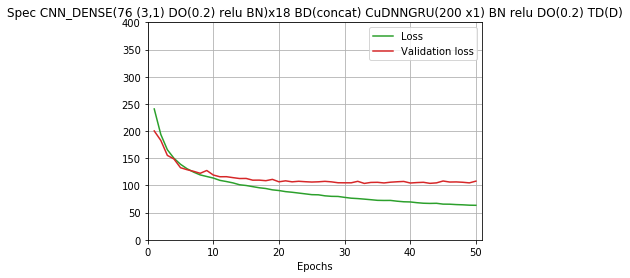

In [6]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=18, cnn_dense=True, filters=76), 
                       rnn_layers=1), 
                       optimizer=SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
                       epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 90)     43560       the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, None, 90)     360         conv1d1[0][0]                    
__________________________________________________________________________________________________
reluC0 (Activation)             (None, None, 90)     0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
dropout_33

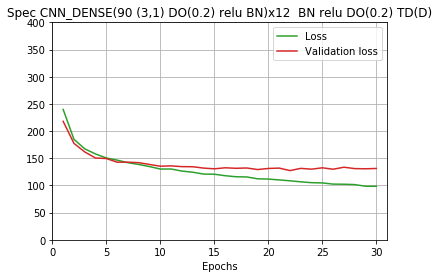

In [9]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dense=True, filters=90), 
                       rnn_layers=0), 
                       optimizer=SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
                       epochs=30)

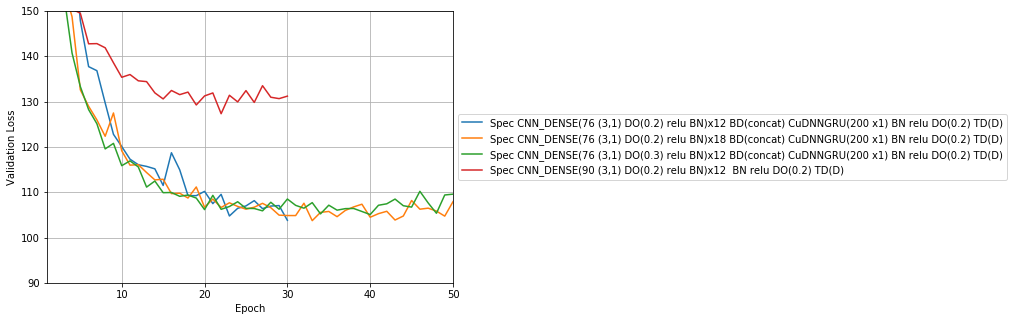

In [14]:
plot_comparison(model_names=\
['Spec CNN_DENSE(76 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) BN relu DO(0.2) TD(D)',
 'Spec CNN_DENSE(76 (3,1) DO(0.2) relu BN)x18 BD(concat) CuDNNGRU(200 x1) BN relu DO(0.2) TD(D)',
 'Spec CNN_DENSE(76 (3,1) DO(0.3) relu BN)x12 BD(concat) CuDNNGRU(200 x1) BN relu DO(0.2) TD(D)',
 'Spec CNN_DENSE(90 (3,1) DO(0.2) relu BN)x12  BN relu DO(0.2) TD(D)'], 
                max_loss=150, min_loss=90)

### Comparing

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_194 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_194 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_195 (Dropout)        (None, None, 200)         0         
__________

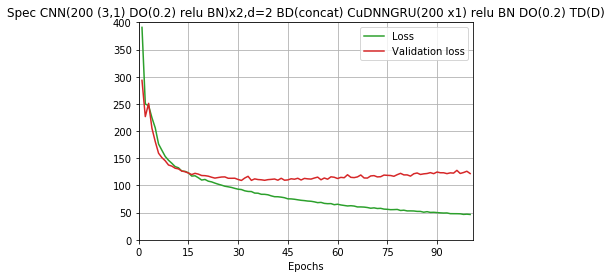

In [65]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=2, dilation=2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_197 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_197 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_198 (Dropout)        (None, None, 200)         0         
__________

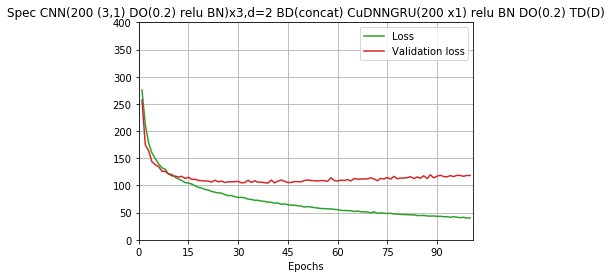

In [66]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=3, dilation=2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_201 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_201 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_202 (Dropout)        (None, None, 200)         0         
__________

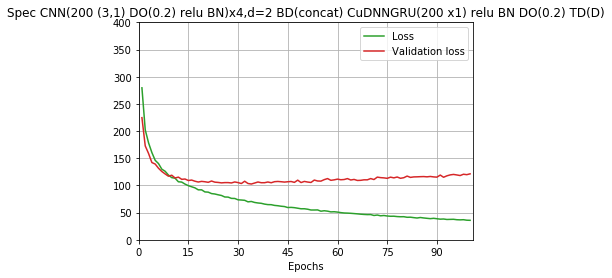

In [67]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=4, dilation=2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_206 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_206 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_207 (Dropout)        (None, None, 200)         0         
__________

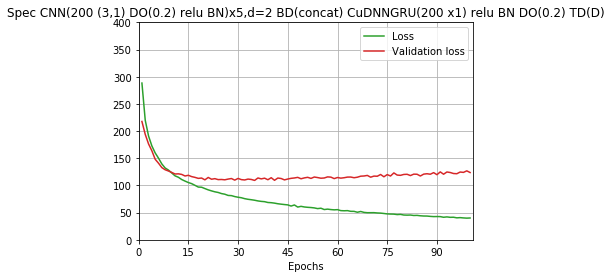

In [68]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=5, dilation=2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_212 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_212 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_213 (Dropout)        (None, None, 200)         0         
__________

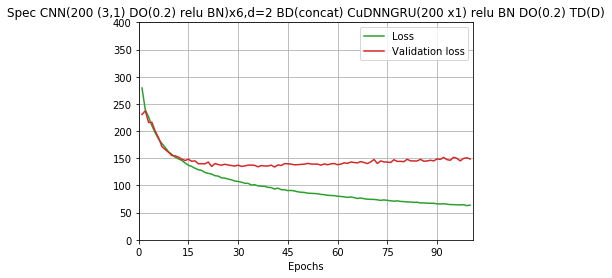

In [69]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=6, dilation=2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

More than 6 layers with dilation=2 does not work

['Spec CNN(200 (3,1) DO(0.2) relu BN)x2,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x3,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x4,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x5,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x6,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)']


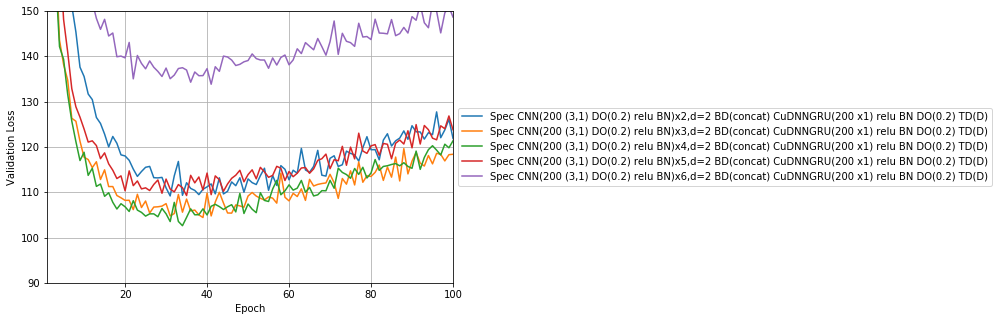

In [81]:
plot_comparison(model_names=
                ['Spec CNN(200 (3,1) DO(0.2) relu BN)x2,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
                 'Spec CNN(200 (3,1) DO(0.2) relu BN)x3,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
                 'Spec CNN(200 (3,1) DO(0.2) relu BN)x4,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
                 'Spec CNN(200 (3,1) DO(0.2) relu BN)x5,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
                 'Spec CNN(200 (3,1) DO(0.2) relu BN)x6,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)'],
                max_loss=150, min_loss=90)

### Comparing

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_306 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_306 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
dropout_307 (Dropout)        (None, None, 200)         0         
__________

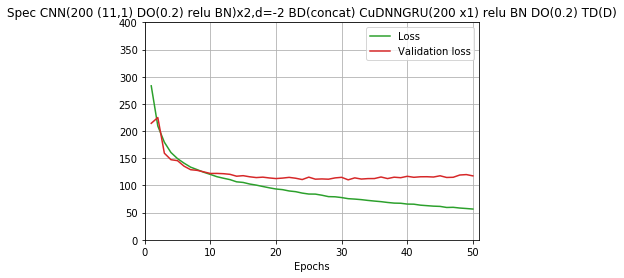

In [104]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=11, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=2, dilation=-2, # cnn_dropout_rate=0.2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_309 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_309 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_310 (Dropout)        (None, None, 200)         0         
__________

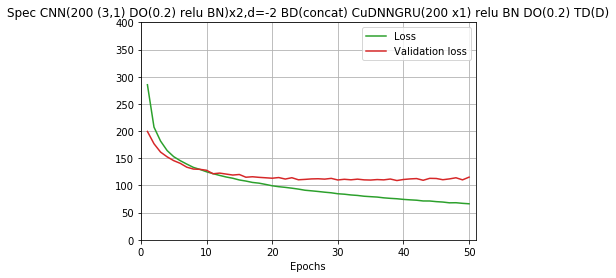

In [105]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=2, dilation=-2, # cnn_dropout_rate=0.2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_312 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_312 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_313 (Dropout)        (None, None, 200)         0         
__________

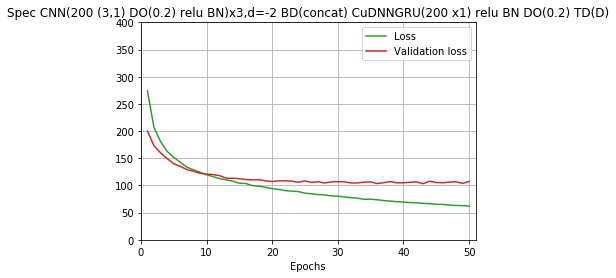

In [106]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=3, dilation=-2, # cnn_dropout_rate=0.2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_316 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_316 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_317 (Dropout)        (None, None, 200)         0         
__________

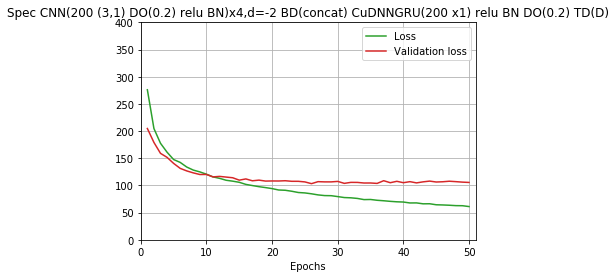

In [107]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=4, dilation=-2, # cnn_dropout_rate=0.2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_321 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_321 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_322 (Dropout)        (None, None, 200)         0         
__________

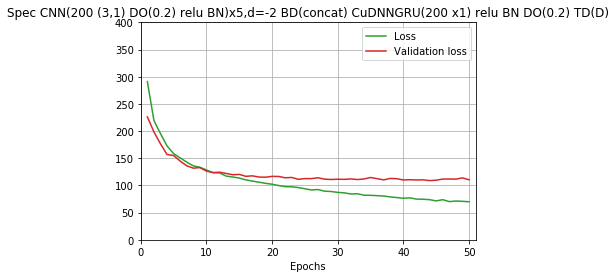

In [108]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=5, dilation=-2, # cnn_dropout_rate=0.2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_327 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_327 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_328 (Dropout)        (None, None, 200)         0         
__________

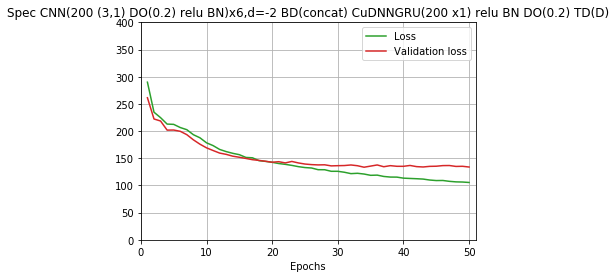

In [109]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=6, dilation=-2, # cnn_dropout_rate=0.2,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

In [110]:
model_names_to_compare = \
    ['Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)'] + \
    model_names_to_compare

['Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,1) DO(0.2) relu BN)x2,d=-2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x2,d=-2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x3,d=-2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x4,d=-2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x5,d=-2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x6,d=-2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)']


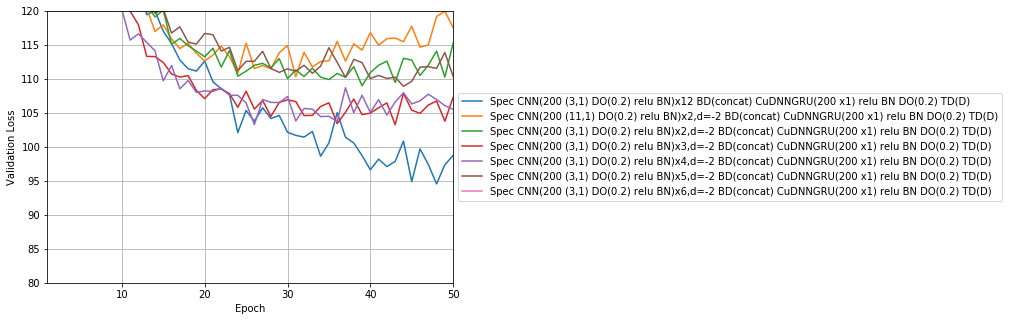

In [111]:
plot_comparison(min_loss=80, max_loss=120, max_epoch=50)

### Comparing

In [112]:
model_names_to_compare=[]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
batch_normalization_276 (Bat (None, None, 200)         800       
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
dropout_276 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
batch_normalization_277 (Bat (None, None, 200)         800       
__________

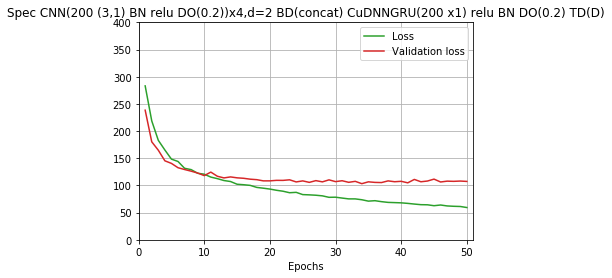

In [84]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=4, dilation=2, cnn_do_bn_order=False,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_281 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_281 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_282 (Dropout)        (None, None, 200)         0         
__________

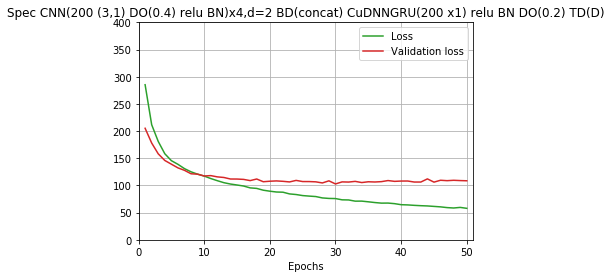

In [85]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=4, dilation=2, cnn_dropout_rate=0.4,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
batch_normalization_286 (Bat (None, None, 200)         800       
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
dropout_286 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
batch_normalization_287 (Bat (None, None, 200)         800       
__________

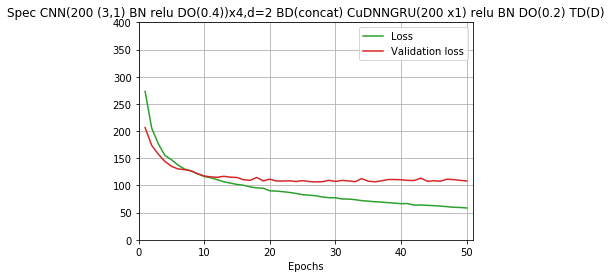

In [86]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="valid", 
                                              cnn_layers=4, dilation=2, cnn_dropout_rate=0.4, cnn_do_bn_order=False, 
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

['Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x4,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) BN relu DO(0.2))x4,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.4) relu BN)x4,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) BN relu DO(0.4))x4,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)']


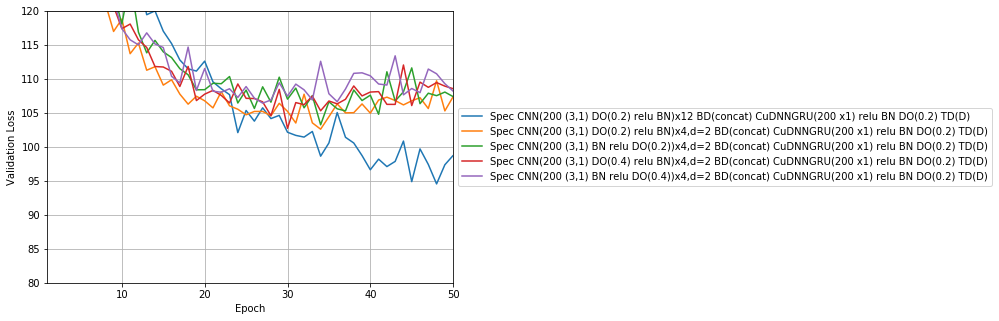

In [96]:
plot_comparison(model_names=\
'Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x4,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) BN relu DO(0.2))x4,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.4) relu BN)x4,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) BN relu DO(0.4))x4,d=2 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
                min_loss=80, max_loss=120, max_epoch=50)

### Comparing

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_388 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_376 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_389 (Dropout)        (None, None, 200)         0         
__________

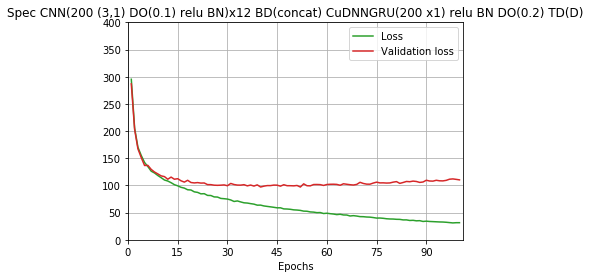

In [135]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dropout_rate=0.1,
                                              cnn_activation_before_bn_do=False), 
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_14 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_15 (Dropout)         (None, None, 200)         0         
__________

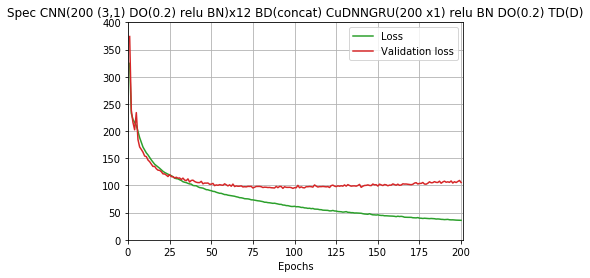

In [7]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dropout_rate=0.2,
                                              cnn_activation_before_bn_do=False), 
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_66 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_66 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_67 (Dropout)         (None, None, 200)         0         
__________

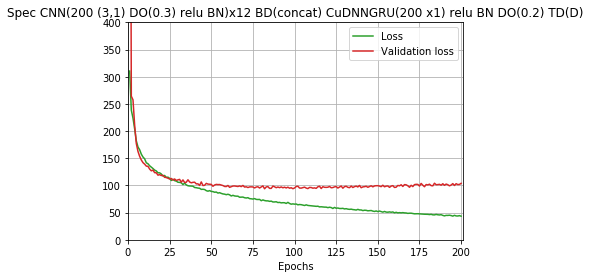

In [17]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dropout_rate=0.3,
                                              cnn_activation_before_bn_do=False), 
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_79 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_79 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_80 (Dropout)         (None, None, 200)         0         
__________

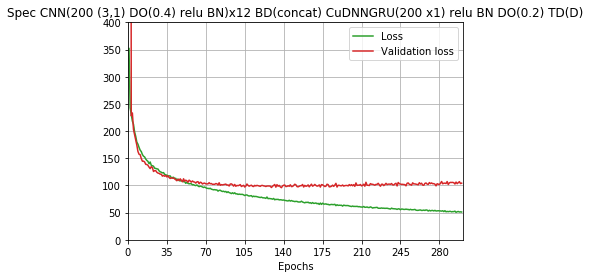

In [18]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dropout_rate=0.4,
                                              cnn_activation_before_bn_do=False), 
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=300)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_92 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_92 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_93 (Dropout)         (None, None, 200)         0         
__________

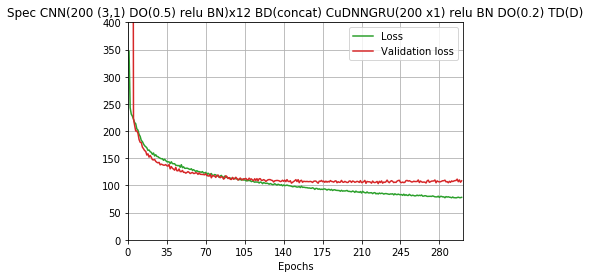

In [19]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dropout_rate=0.5,
                                              cnn_activation_before_bn_do=False), 
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=300)

['Spec CNN(200 (3,1) DO(0.1) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.3) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.4) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.5) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)']


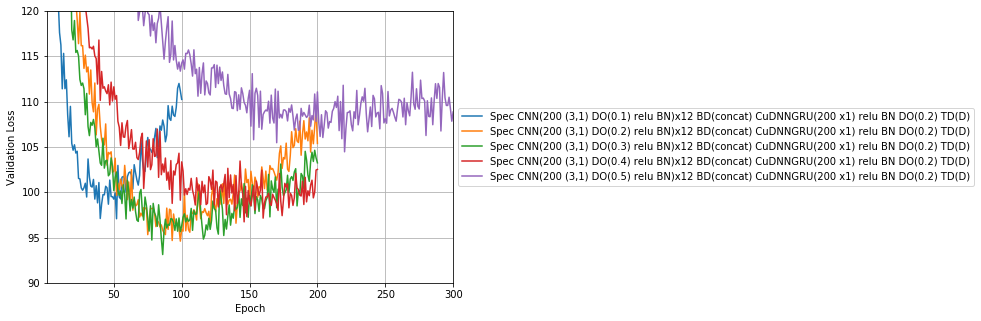

In [16]:
plot_comparison(model_names = 
        ['Spec CNN(200 (3,1) DO(0.1) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
         'Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
         'Spec CNN(200 (3,1) DO(0.3) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
         'Spec CNN(200 (3,1) DO(0.4) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
         'Spec CNN(200 (3,1) DO(0.5) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)'],                
                max_loss=120, min_loss=90)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_105 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_105 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_106 (Dropout)        (None, None, 200)         0         
__________

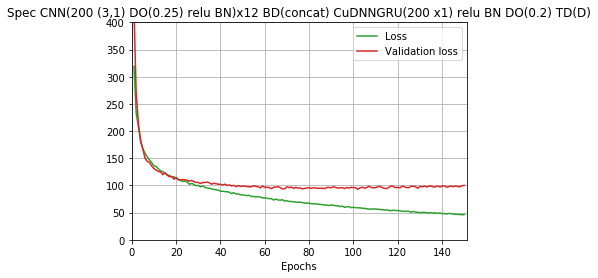

In [20]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dropout_rate=0.25,
                                              cnn_activation_before_bn_do=False), 
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=150)

['Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.25) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.3) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)']


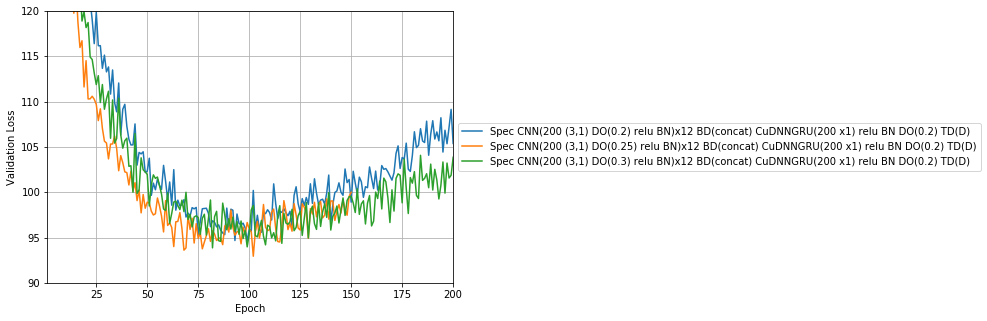

In [21]:
plot_comparison(model_names = 
        ['Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
         'Spec CNN(200 (3,1) DO(0.25) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
         'Spec CNN(200 (3,1) DO(0.3) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)'],                
                max_loss=120, min_loss=90)

## Comparing

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
batch_normalization_89 (Batc (None, None, 200)         800       
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
dropout_89 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
batch_normalization_90 (Batc (None, None, 200)         800       
__________

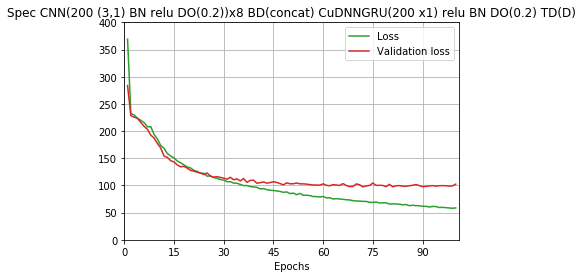

In [65]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=8,
                                              cnn_activation_before_bn_do=False,
                                              cnn_do_bn_order=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_98 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_98 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_99 (Dropout)         (None, None, 200)         0         
__________

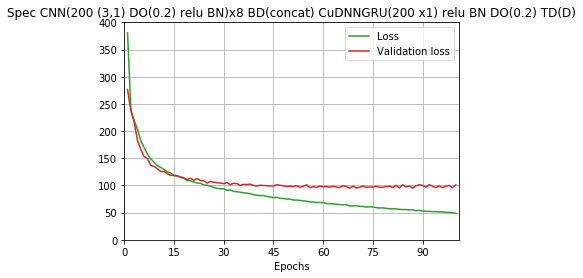

In [66]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=8,
                                              cnn_activation_before_bn_do=False,
                                              cnn_do_bn_order=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
batch_normalization_107 (Bat (None, None, 200)         800       
_________________________________________________________________
dropout_107 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
batch_normalization_108 (Bat (None, None, 200)         800       
_________________________________________________________________
dropout_108 (Dropout)        (None, None, 200)         0         
__________

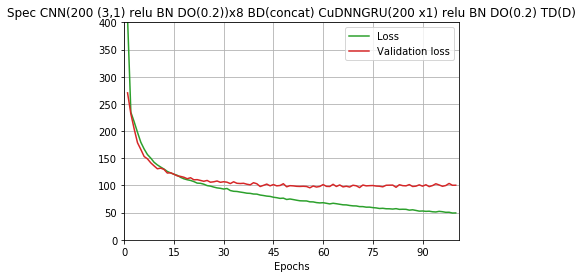

In [67]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=8,
                                              cnn_activation_before_bn_do=True,
                                              cnn_do_bn_order=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_116 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_116 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_117 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_117 (Bat (None, None, 200)         800       
__________

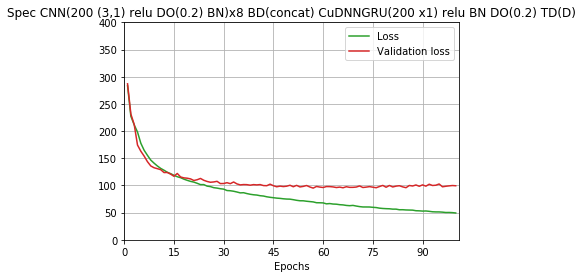

In [68]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=8,
                                              cnn_activation_before_bn_do=True,
                                              cnn_do_bn_order=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=100)

['Spec CNN(200 (3,1) BN relu DO(0.2))x8 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x8 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) relu BN DO(0.2))x8 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) relu DO(0.2) BN)x8 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)']


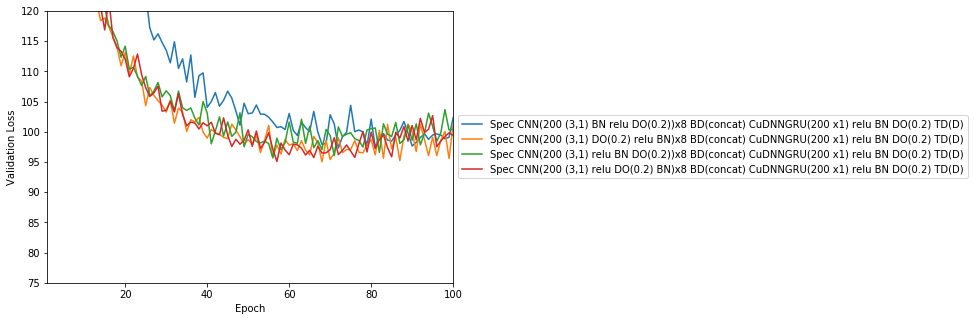

In [70]:
plot_comparison(max_loss=120, min_loss=75)

### Comparing...

In [80]:
model_names_to_compare = []

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 100)    80600       the_input[0][0]                  
__________________________________________________________________________________________________
dropout_151 (Dropout)           (None, None, 100)    0           conv1d1[0][0]                    
__________________________________________________________________________________________________
reluC0 (Activation)             (None, None, 100)    0           dropout_151[0][0]                
__________________________________________________________________________________________________
batch_norm

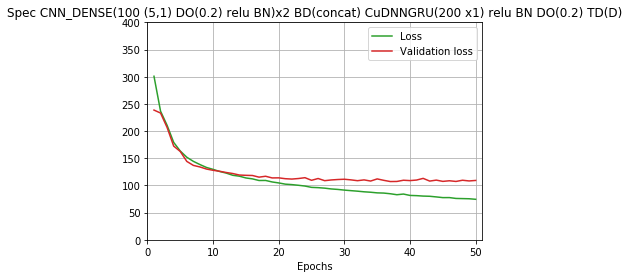

In [81]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=5, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=2, cnn_dense=True, filters=100,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 80)     64480       the_input[0][0]                  
__________________________________________________________________________________________________
dropout_154 (Dropout)           (None, None, 80)     0           conv1d1[0][0]                    
__________________________________________________________________________________________________
reluC0 (Activation)             (None, None, 80)     0           dropout_154[0][0]                
__________________________________________________________________________________________________
batch_norm

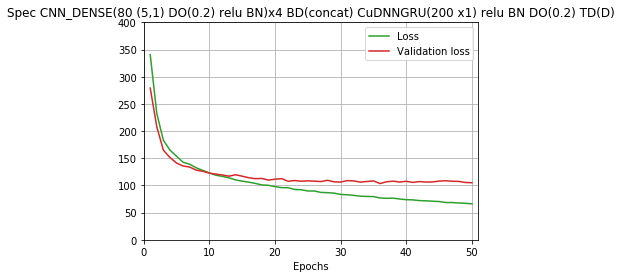

In [82]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=5, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=4,  cnn_dense=True, filters=80,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 80)     38720       the_input[0][0]                  
__________________________________________________________________________________________________
dropout_159 (Dropout)           (None, None, 80)     0           conv1d1[0][0]                    
__________________________________________________________________________________________________
reluC0 (Activation)             (None, None, 80)     0           dropout_159[0][0]                
__________________________________________________________________________________________________
batch_norm

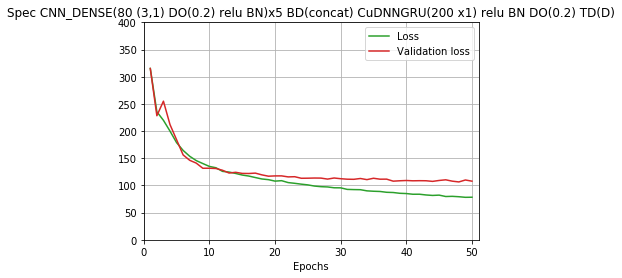

In [85]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=5,  cnn_dense=True, filters=80,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 50)     24200       the_input[0][0]                  
__________________________________________________________________________________________________
dropout_165 (Dropout)           (None, None, 50)     0           conv1d1[0][0]                    
__________________________________________________________________________________________________
reluC0 (Activation)             (None, None, 50)     0           dropout_165[0][0]                
__________________________________________________________________________________________________
batch_norm

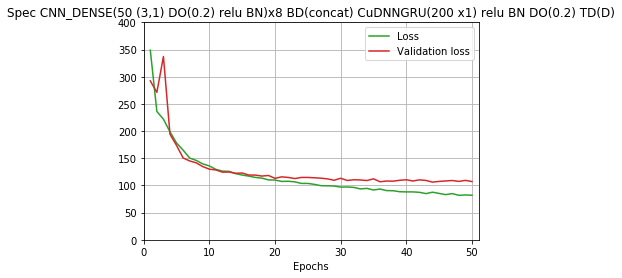

In [86]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=8,  cnn_dense=True, filters=50,
                                              cnn_activation_before_bn_do=False), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=1), epochs=50)

['Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (3,1) DO(0.2) relu BN)x8 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN_DENSE(80 (5,1) DO(0.2) relu BN)x4 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN_DENSE(80 (3,1) DO(0.2) relu BN)x5 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN_DENSE(50 (3,1) DO(0.2) relu BN)x8 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)']


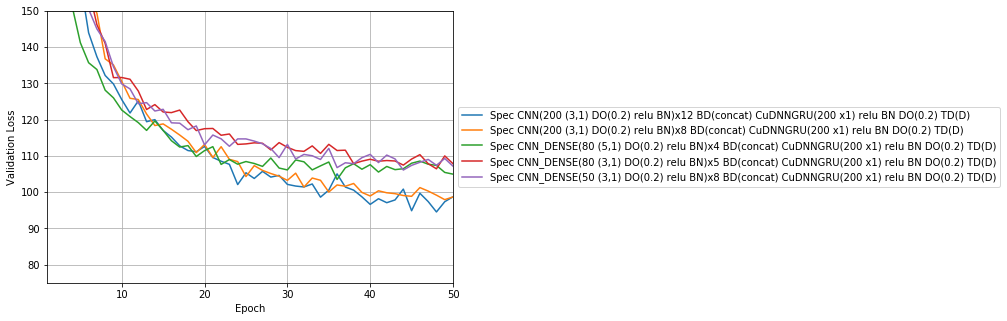

In [115]:
plot_comparison(
    ['Spec CNN(200 (3,1) DO(0.2) relu BN)x12 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
     'Spec CNN(200 (3,1) DO(0.2) relu BN)x8 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
     'Spec CNN_DENSE(80 (5,1) DO(0.2) relu BN)x4 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
     'Spec CNN_DENSE(80 (3,1) DO(0.2) relu BN)x5 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
     'Spec CNN_DENSE(50 (3,1) DO(0.2) relu BN)x8 BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)'],
     max_loss=150, min_loss=75, max_epoch=50)

### Comparing...

In [126]:
model_names_to_compare = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_359 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_350 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_53 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNGRU)              (None, None, 200)         361200    
__________

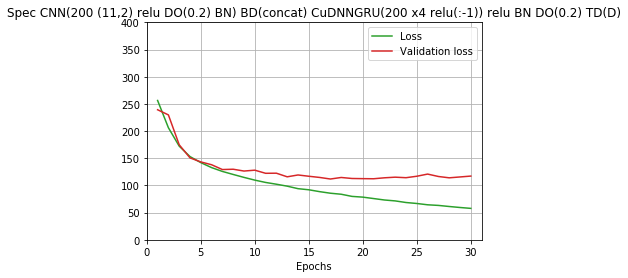

In [127]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=4, 
                       rnn_bn = False, rnn_dropout_rate = 0), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_361 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_352 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_54 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_353 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

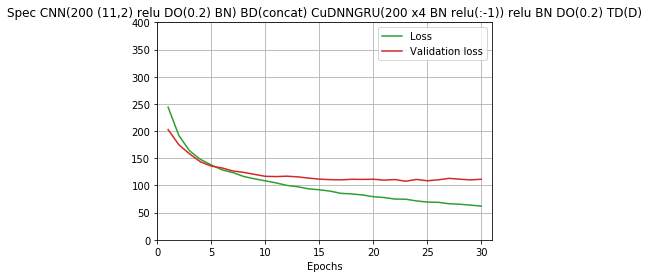

In [128]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=4, 
                       rnn_bn = True, rnn_dropout_rate = 0), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_363 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_357 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_55 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
_________________________________________________________________
dropout_364 (Dropout)        (None, None, 400)         0         
__________

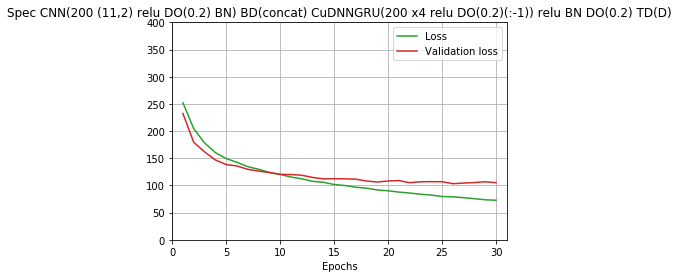

In [129]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=4, 
                       rnn_bn = False, rnn_dropout_rate = 0.2), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_368 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_359 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_56 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
_________________________________________________________________
dropout_369 (Dropout)        (None, None, 400)         0         
__________

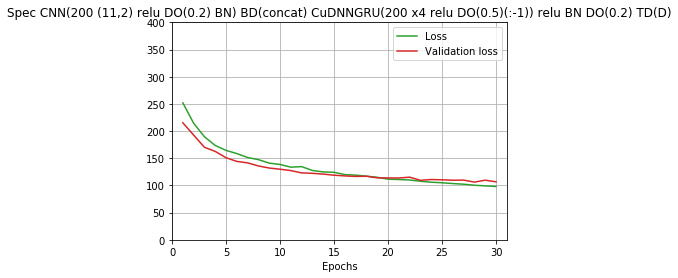

In [130]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=4, 
                       rnn_bn = False, rnn_dropout_rate = 0.5), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_373 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_361 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_57 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_362 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

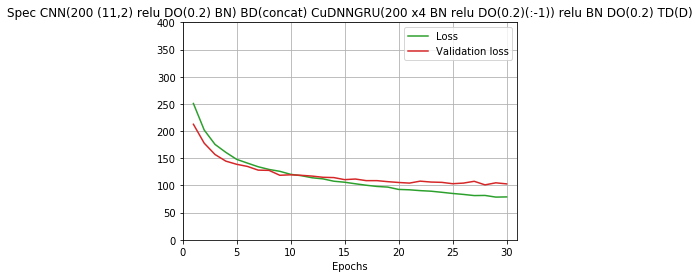

In [131]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=4, 
                       rnn_bn = True, rnn_dropout_rate = 0.2), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_378 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_366 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_58 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_367 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

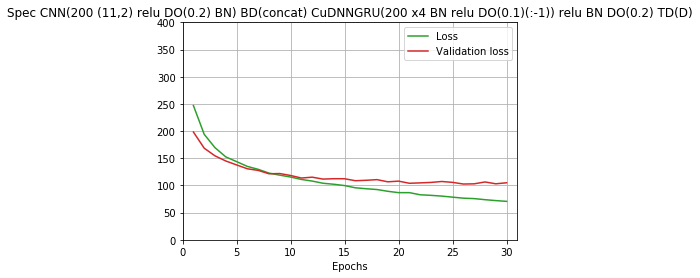

In [132]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=4, 
                       rnn_bn = True, rnn_dropout_rate = 0.1), epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_383 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_371 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_59 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_372 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

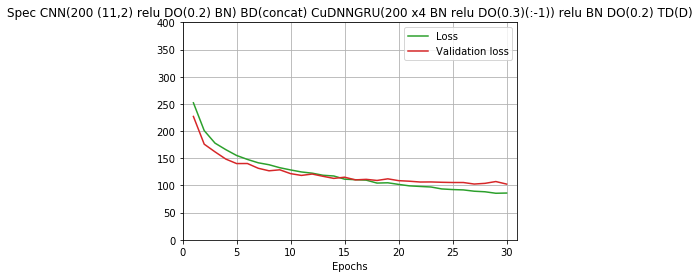

In [133]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=4, 
                       rnn_bn = True, rnn_dropout_rate = 0.3), epochs=30)

['Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 relu(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 BN relu(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 relu DO(0.5)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.1)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.3)(:-1)) relu BN DO(0.2) TD(D)']


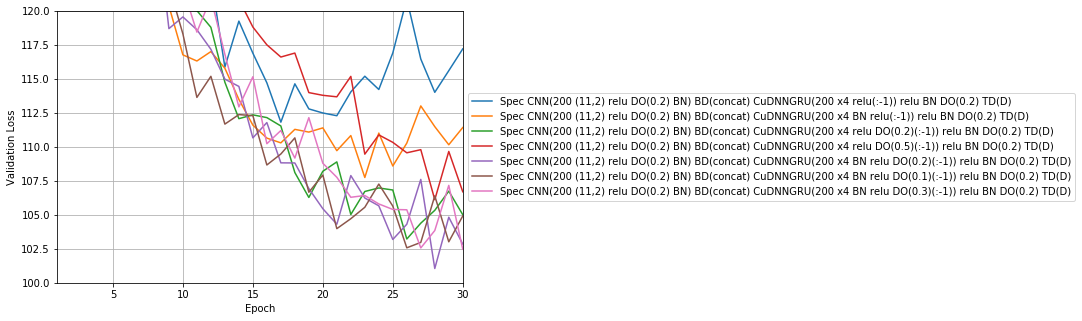

In [8]:
plot_comparison(model_names=
['Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 relu(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 BN relu(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 relu DO(0.5)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.1)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.3)(:-1)) relu BN DO(0.2) TD(D)'],
                max_loss=120, min_loss=100, max_epoch=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
relu (Activation)            (None, None, 400)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 400)         1600      
__________

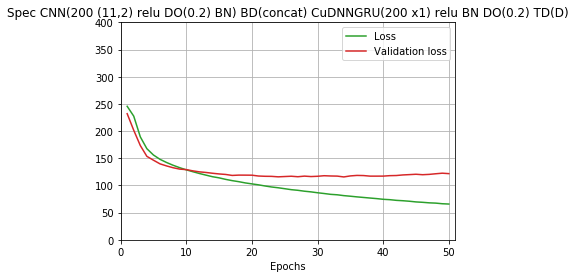

In [9]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=1, rnn_dropout_rate = 0.2), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

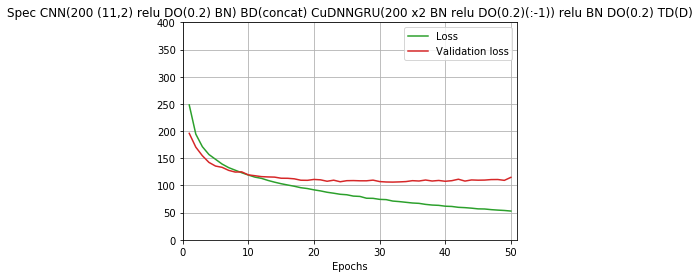

In [10]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=2, rnn_dropout_rate = 0.2), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_40 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
batch_normalization_40 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_41 (Batc (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

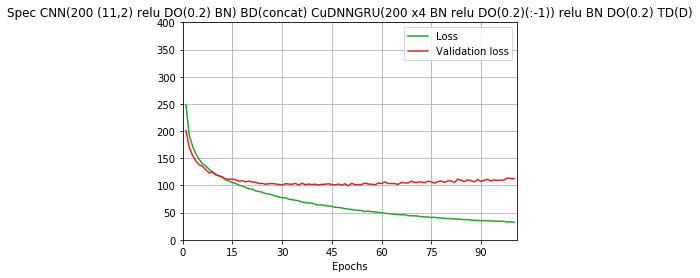

In [16]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=4, rnn_dropout_rate = 0.2), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_45 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
batch_normalization_45 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_46 (Batc (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

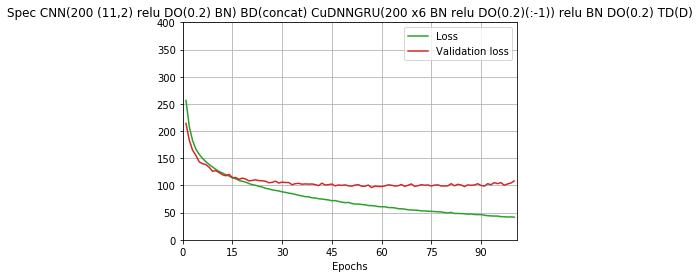

In [17]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=6, rnn_dropout_rate = 0.2), epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_74 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
batch_normalization_74 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_75 (Batc (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

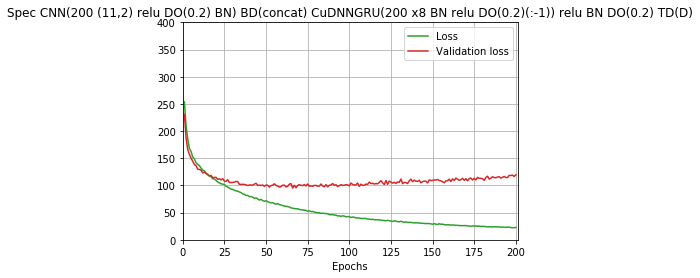

In [26]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=8, rnn_dropout_rate = 0.2), epochs=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_83 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
batch_normalization_83 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_84 (Batc (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

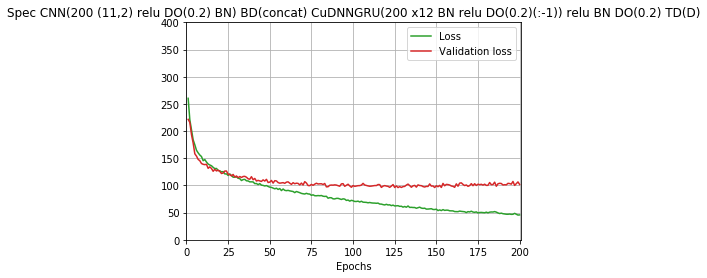

In [27]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(), rnn_layers=12, rnn_dropout_rate = 0.2), epochs=200)

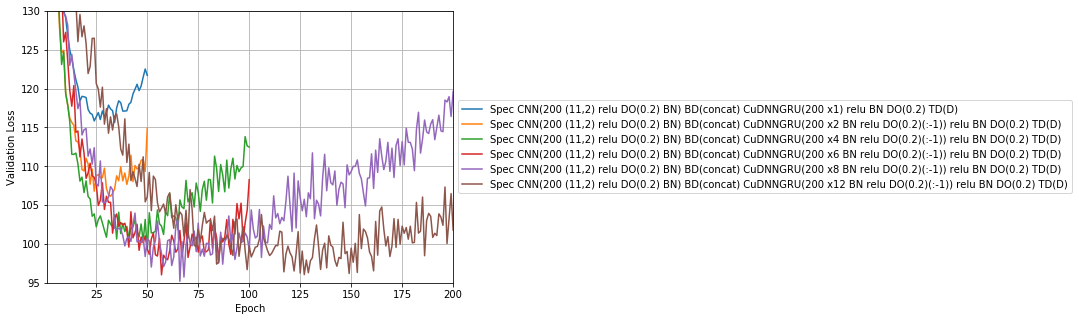

In [28]:
plot_comparison(model_names=\
['Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x2 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x6 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x8 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x12 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)'],
               min_loss=95, max_loss=130)

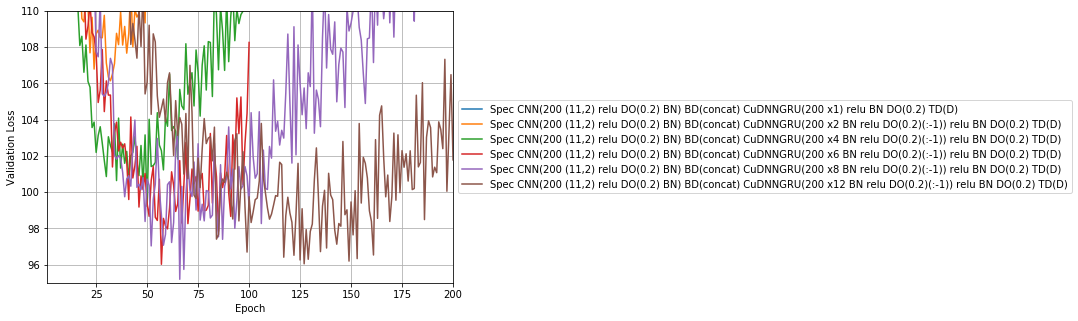

In [29]:
plot_comparison(model_names=\
['Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x1) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x2 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x6 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x8 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x12 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)'],
               min_loss=95, max_loss=110)

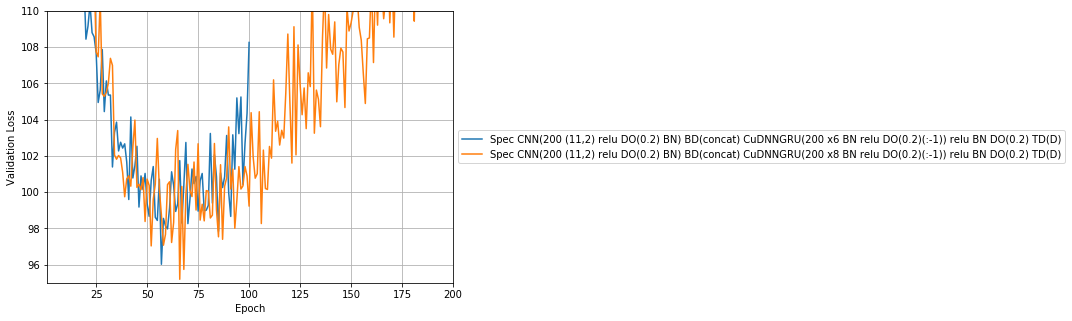

In [31]:
plot_comparison(model_names=\
['Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x6 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x8 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)'],
               min_loss=95, max_loss=110)

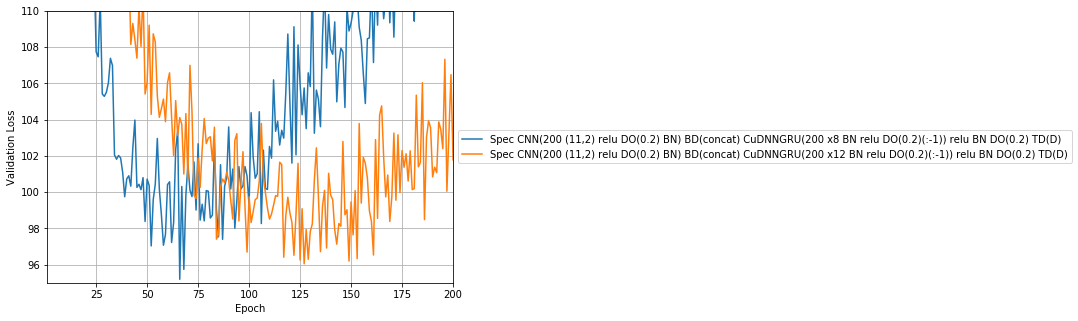

In [30]:
plot_comparison(model_names=\
['Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x8 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.2) BN) BD(concat) CuDNNGRU(200 x12 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)'],
               min_loss=95, max_loss=110)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_151 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_149 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_24 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_150 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

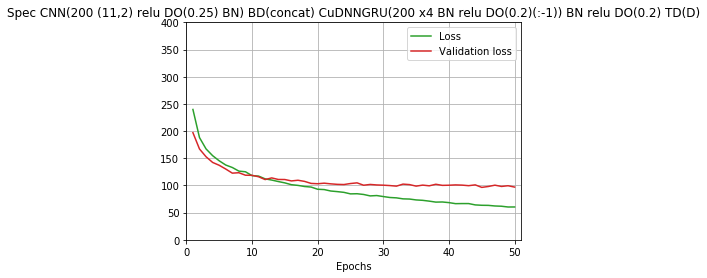

In [46]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                       activation_before_bn_do = False, do_bn_order = False), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_121 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_121 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_18 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_122 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

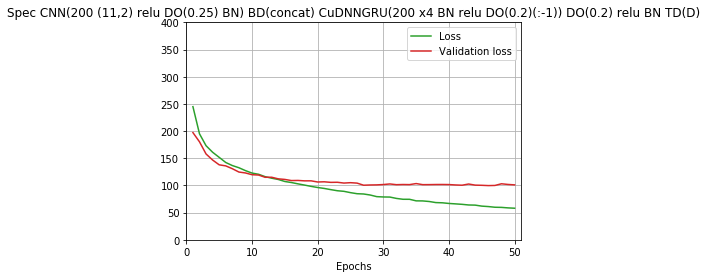

In [39]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                       activation_before_bn_do = False, do_bn_order = True), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_146 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_144 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_23 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_145 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

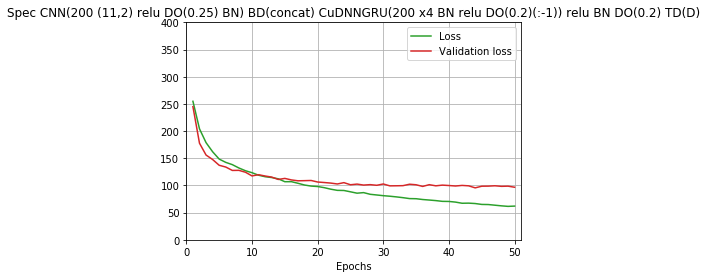

In [45]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                       activation_before_bn_do = True, do_bn_order = False), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_131 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_131 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_20 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_132 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

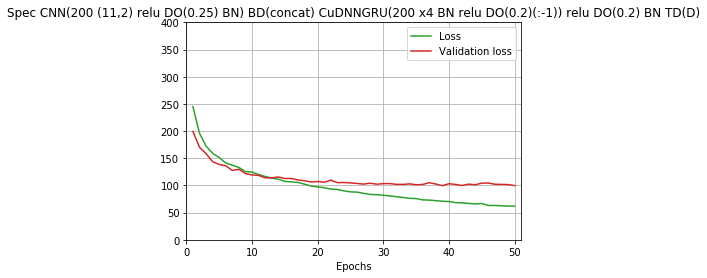

In [41]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                       activation_before_bn_do = True, do_bn_order = True), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_161 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_158 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_26 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_159 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

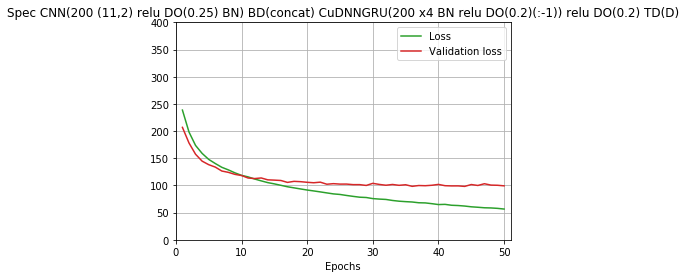

In [48]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                       activation_before_bn_do = True, bn = False), epochs=50)

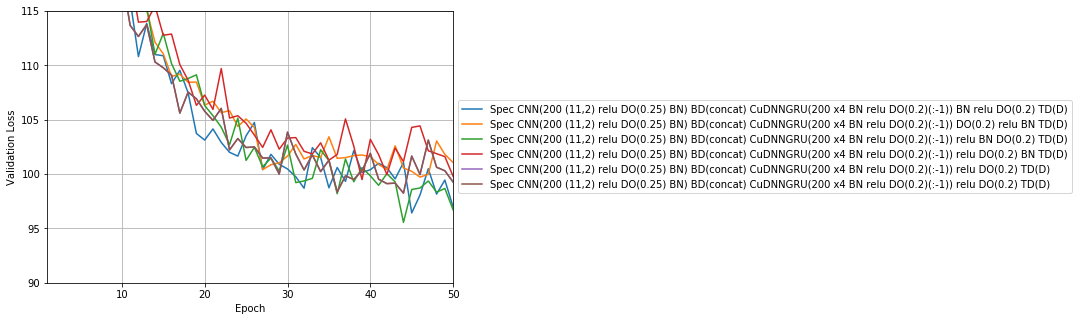

In [53]:
plot_comparison(model_names=\
[ 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.2) TD(D)',
  'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) DO(0.2) relu BN TD(D)',
  'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) relu BN DO(0.2) TD(D)',
  'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) relu DO(0.2) BN TD(D)',
  'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) relu DO(0.2) TD(D)',
  'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) relu DO(0.2) TD(D)'], 
               min_loss = 90, max_loss=115)

### Comparing...

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_191 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_187 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_32 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_188 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

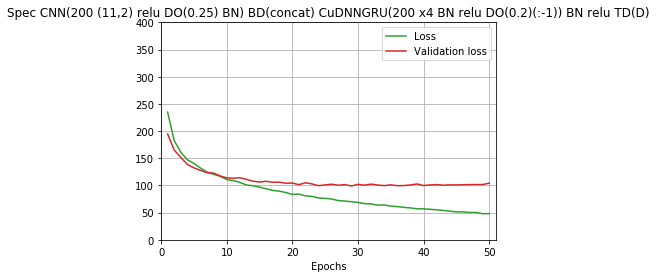

In [61]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                      dropout_rate=0), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_166 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_162 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_27 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_163 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

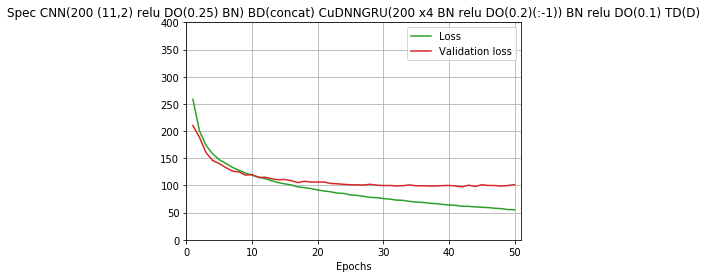

In [55]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                      dropout_rate=0.1), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_171 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_167 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_28 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_168 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

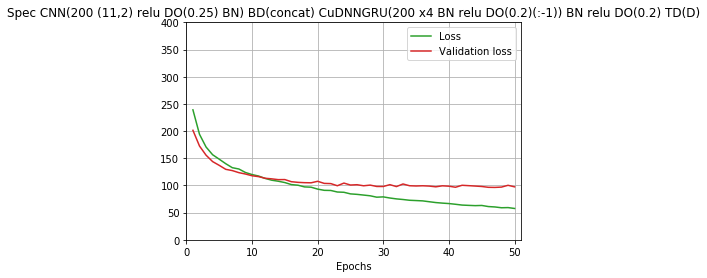

In [56]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                      dropout_rate=0.2), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_176 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_172 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_29 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_173 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

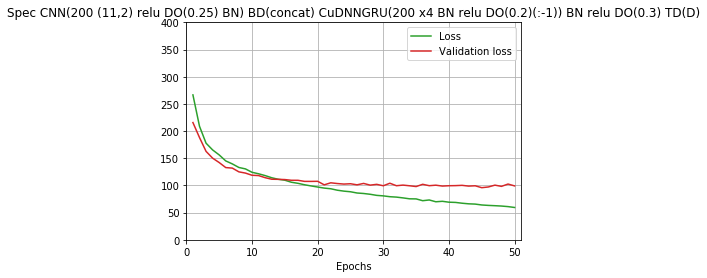

In [57]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                      dropout_rate=0.3), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_181 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_177 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_30 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_178 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

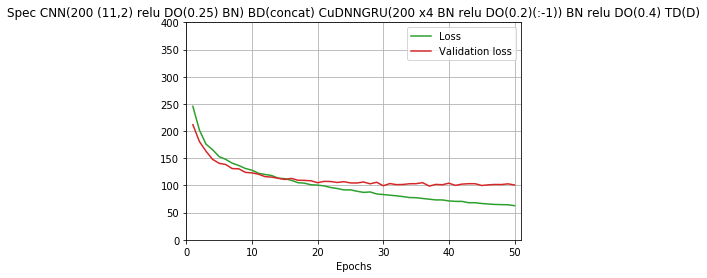

In [58]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                      dropout_rate=0.4), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_186 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_182 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_31 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_183 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

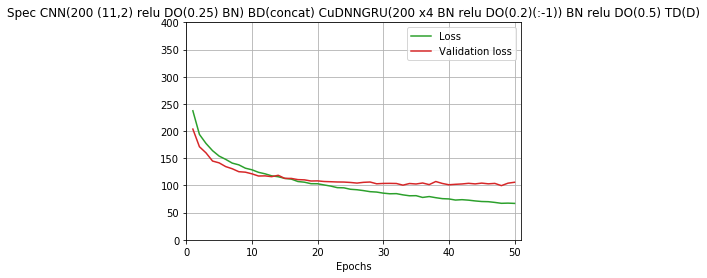

In [59]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                      dropout_rate=0.5), epochs=50)

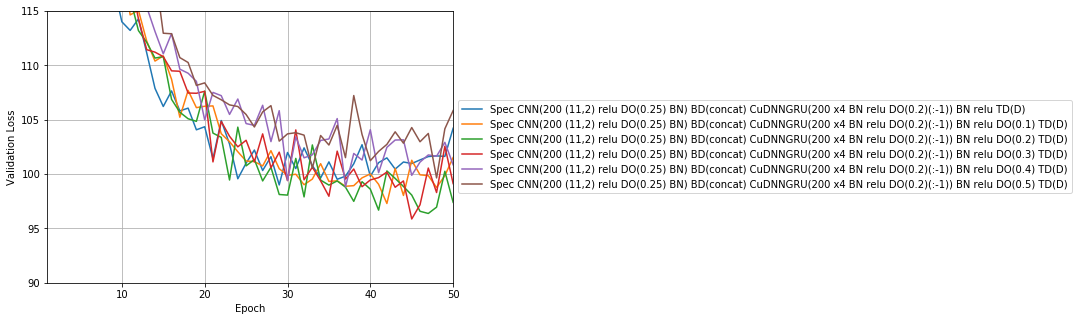

In [63]:
plot_comparison(model_names=\
['Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu TD(D)', 
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.1) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.3) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.4) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.5) TD(D)'],
                min_loss = 90, max_loss=115)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_195 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_192 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_33 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_193 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
__________

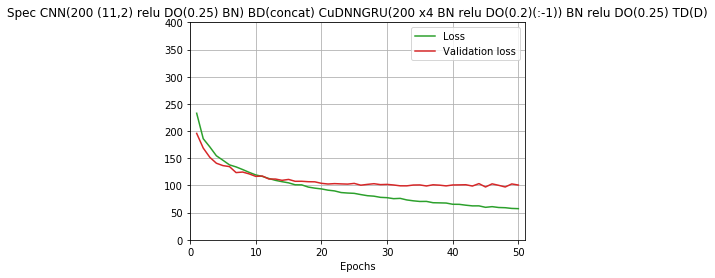

In [64]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_dropout_rate=0.25), rnn_layers=4, rnn_dropout_rate = 0.2, 
                      dropout_rate=0.25), epochs=50)

In [65]:
print_model_names()

['Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.1) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.3) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.4) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.5) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.25) TD(D)']


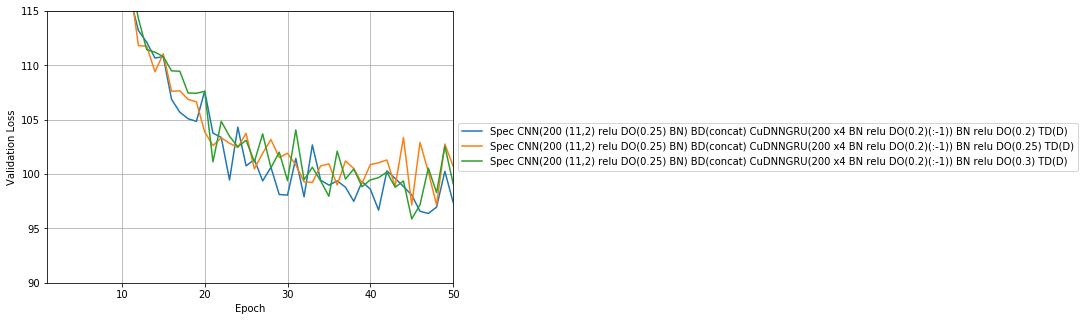

In [66]:
plot_comparison(model_names=\
['Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.2) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.25) TD(D)',
 'Spec CNN(200 (11,2) relu DO(0.25) BN) BD(concat) CuDNNGRU(200 x4 BN relu DO(0.2)(:-1)) BN relu DO(0.3) TD(D)'],
                min_loss = 90, max_loss=115)

### Final?

In [ ]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dropout_rate=0.25,
                                              cnn_activation_before_bn_do=True,
                                              cnn_do_bn_order=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, 
                       rnn_layers=1, rnn_dropout_rate = 0.2, 
                       dropout_rate=0.3), epochs=150)

In [ ]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=1, cnn_dropout_rate=0.25,
                                              cnn_activation_before_bn_do=True,
                                              cnn_do_bn_order=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, 
                       rnn_layers=8, rnn_dropout_rate = 0.2, 
                       dropout_rate=0.3), epochs=150)

In [ ]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                              cnn_layers=12, cnn_dropout_rate=0.25,
                                              cnn_activation_before_bn_do=True,
                                              cnn_do_bn_order=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, 
                       rnn_layers=8, rnn_dropout_rate = 0.2, 
                       dropout_rate=0.3), epochs=300)

In [ ]:
plot_comparison()

In [54]:
model_names_to_compare = []

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 200)    354400      the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, None, 200)    800         conv1d1[0][0]                    
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, None, 361)    0           the_input[0][0]                  
                                                                 batch_normalization_34[0][0]     
__________

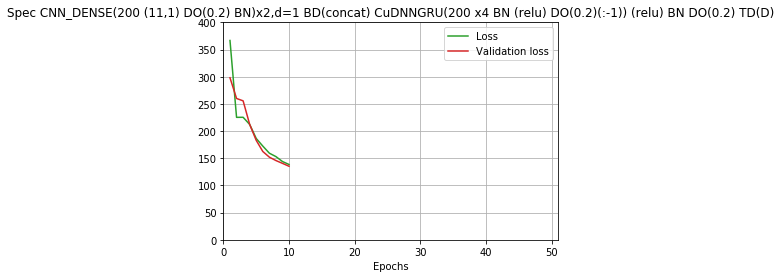

In [12]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_layers=2, conv_stride=1, conv_border_mode="same", cnn_dense=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=4), epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 200)    354400      the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, None, 200)    800         conv1d1[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, None, 361)    0           the_input[0][0]                  
                                                                 batch_normalization_8[0][0]      
__________

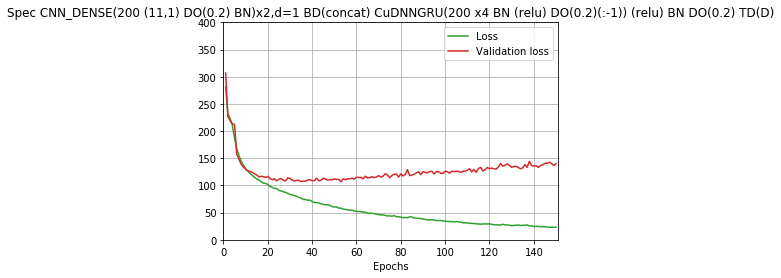

In [5]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_layers=2, conv_stride=1, conv_border_mode="same", cnn_dense=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=4), epochs=150)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 200)    354400      the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_352 (BatchN (None, None, 200)    800         conv1d1[0][0]                    
__________________________________________________________________________________________________
concatenate_192 (Concatenate)   (None, None, 361)    0           the_input[0][0]                  
                                                                 batch_normalization_352[0][0]    
__________

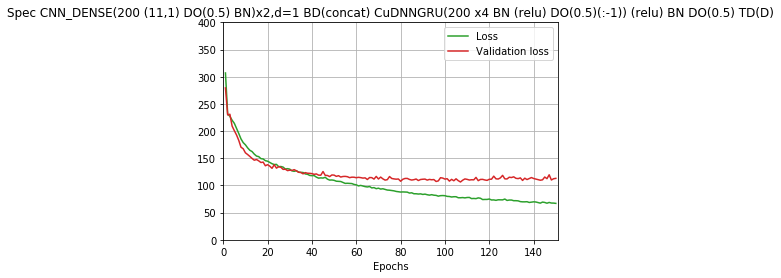

In [96]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_layers=2, conv_stride=1, conv_border_mode="same", cnn_dense=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=4, dropout_rate=0.5), epochs=150)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 200)    354400      the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_310 (BatchN (None, None, 200)    800         conv1d1[0][0]                    
__________________________________________________________________________________________________
concatenate_175 (Concatenate)   (None, None, 361)    0           the_input[0][0]                  
                                                                 batch_normalization_310[0][0]    
__________

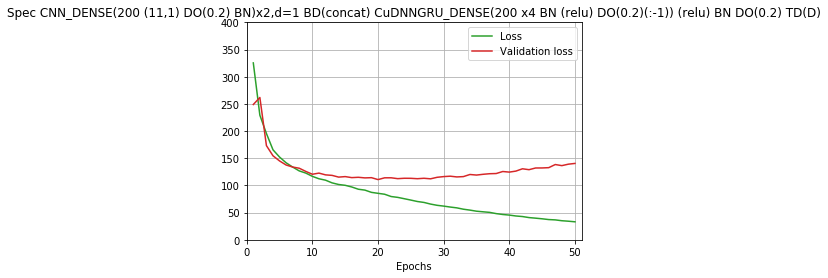

In [89]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_layers=2, conv_stride=1, conv_border_mode="same", cnn_dense=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=4, rnn_denseense=True), epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 200)    354400      the_input[0][0]                  
__________________________________________________________________________________________________
dropout_372 (Dropout)           (None, None, 200)    0           conv1d1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_292 (BatchN (None, None, 200)    800         dropout_372[0][0]                
__________________________________________________________________________________________________
concatenat

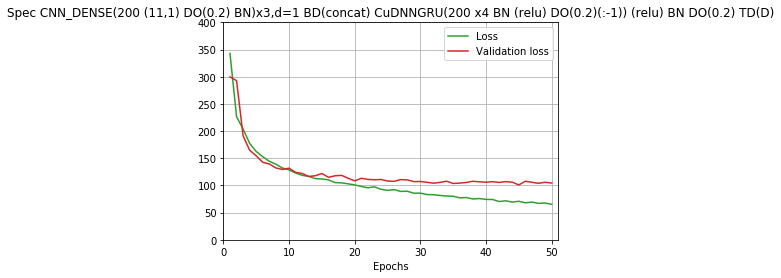

In [85]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_layers=3, conv_stride=1, conv_border_mode="same", cnn_dense=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=4), epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 200)    354400      the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 200)    800         conv1d1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 361)    0           the_input[0][0]                  
                                                                 batch_normalization_1[0][0]      
__________

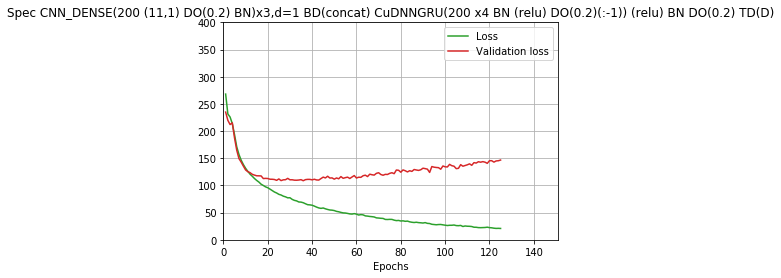

In [4]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_layers=3, conv_stride=1, conv_border_mode="same", cnn_dense=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=4), epochs=150)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 200)    161200      the_input[0][0]                  
__________________________________________________________________________________________________
dropout_353 (Dropout)           (None, None, 200)    0           conv1d1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_273 (BatchN (None, None, 200)    800         dropout_353[0][0]                
__________________________________________________________________________________________________
concatenat

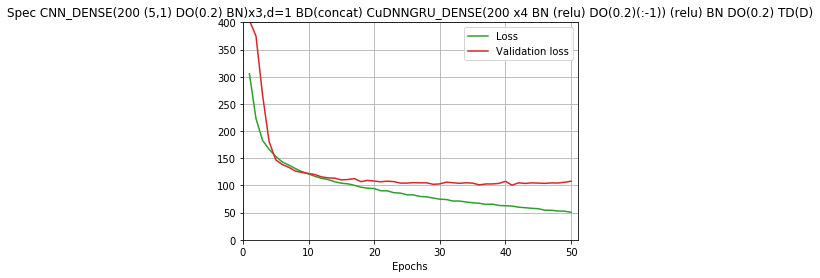

In [82]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_layers=3, kernel_size=5, conv_stride=1, 
                                              conv_border_mode="same", cnn_dense=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=4, rnn_dense=True), epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 200)    161200      the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_326 (BatchN (None, None, 200)    800         conv1d1[0][0]                    
__________________________________________________________________________________________________
concatenate_182 (Concatenate)   (None, None, 361)    0           the_input[0][0]                  
                                                                 batch_normalization_326[0][0]    
__________

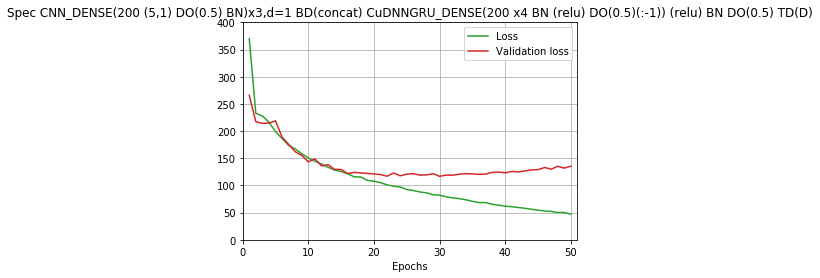

In [92]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(cnn_layers=3, kernel_size=5, conv_stride=1, 
                                              conv_border_mode="same", cnn_dense=True), 
                       bd_merge=M.BidirectionalMerge.concat,
                       rnn_type=M.RNNType.GRU, rnn_layers=4, rnn_dense=True, dropout_rate=0.5), epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 200)    354400      the_input[0][0]                  
__________________________________________________________________________________________________
dropout_335 (Dropout)           (None, None, 200)    0           conv1d1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_255 (BatchN (None, None, 200)    800         dropout_335[0][0]                
__________________________________________________________________________________________________
bidirectio

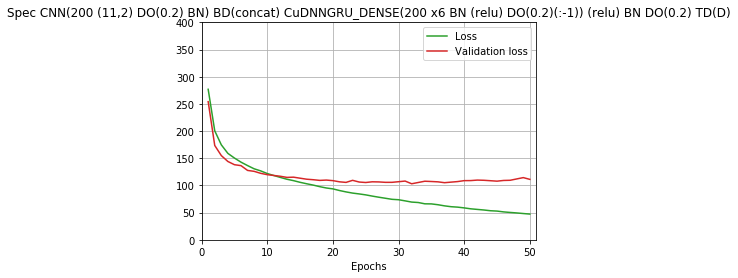

In [79]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(),
                       bd_merge=M.BidirectionalMerge.concat, 
                       rnn_type=M.RNNType.GRU, rnn_units=200, rnn_layers=6, rnn_dense=True), epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
conv1d1 (Conv1D)                (None, None, 200)    354400      the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_333 (BatchN (None, None, 200)    800         conv1d1[0][0]                    
__________________________________________________________________________________________________
bidirectional_49 (Bidirectional (None, None, 400)    482400      batch_normalization_333[0][0]    
__________________________________________________________________________________________________
batch_norm

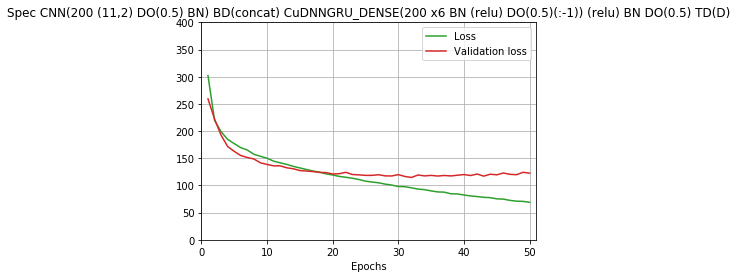

In [93]:
train_model(M.RNNModel(cnn_config=M.CNNConfig(),
                       bd_merge=M.BidirectionalMerge.concat, 
                       rnn_type=M.RNNType.GRU, rnn_units=200, rnn_layers=6, rnn_dense=True, 
                       dropout_rate=0.5), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d3 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_349 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_51 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_350 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
_________________________________________________________________
dropout_416 (Dropout)        (None, None, 400)         0         
__________

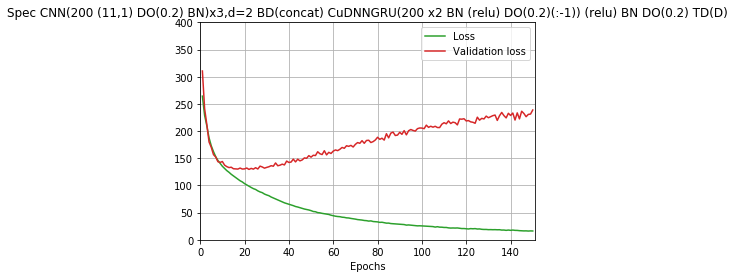

In [95]:
cnn_config_3d=M.CNNConfig(filters=200, kernel_size=11, conv_stride=1, conv_border_mode='valid', cnn_layers=3, dilation=2)
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_3d, 
                       rnn_type=M.RNNType.GRU, rnn_layers=2), epochs=150)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d3 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_342 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_50 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
batch_normalization_343 (Bat (None, None, 400)         1600      
_________________________________________________________________
reluR0 (Activation)          (None, None, 400)         0         
_________________________________________________________________
dropout_412 (Dropout)        (None, None, 400)         0         
__________

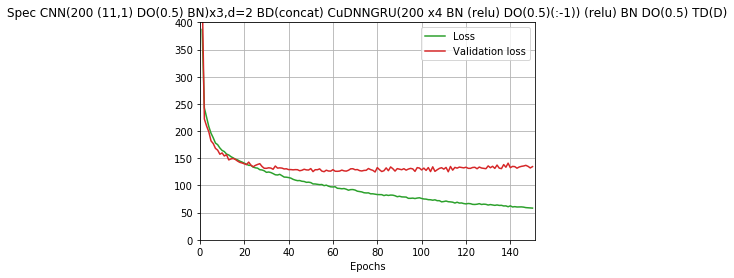

In [94]:
cnn_config_3d=M.CNNConfig(filters=200, kernel_size=11, conv_stride=1, conv_border_mode='valid', cnn_layers=3, dilation=2)
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_3d, 
                       rnn_type=M.RNNType.GRU, dropout_rate=0.5, rnn_layers=4), epochs=150)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_222 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_137 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_48 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
dropout_223 (Dropout)        (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNGRU)              (None, None, 200)         361200    
__________

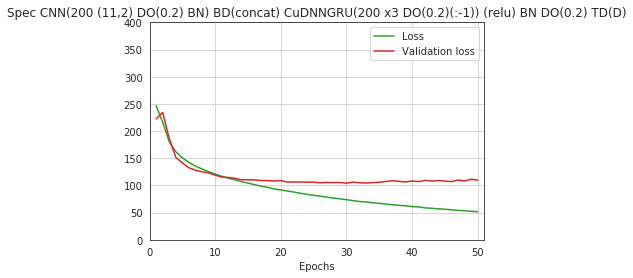

In [103]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_0, 
                       rnn_type=M.RNNType.GRU, rnn_layers=3), epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 26)          0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         57400     
_________________________________________________________________
dropout_207 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_130 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_44 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
dropout_208 (Dropout)        (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNGRU)              (None, None, 200)         361200    
__________

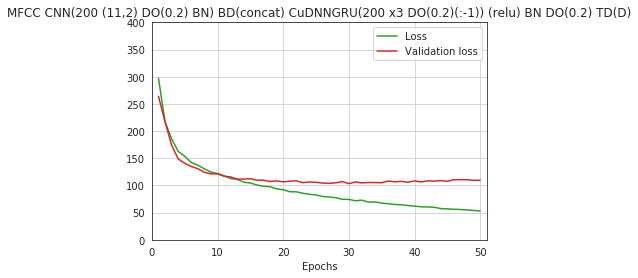

In [99]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_0, 
                       rnn_type=M.RNNType.GRU, rnn_layers=3), spectrogram=False, epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 26)          0         
_________________________________________________________________
bidirectional_47 (Bidirectio (None, None, 400)         273600    
_________________________________________________________________
dropout_219 (Dropout)        (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNGRU)              (None, None, 200)         361200    
_________________________________________________________________
dropout_220 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
rnn3 (CuDNNGRU)              (None, None, 200)         241200    
_________________________________________________________________
relu (Activation)            (None, None, 200)         0         
__________

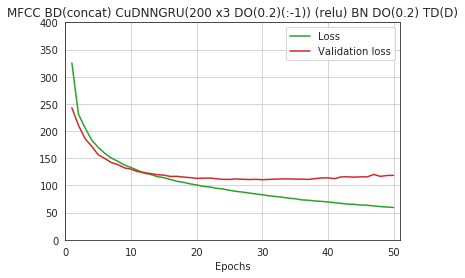

In [102]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, 
                       rnn_type=M.RNNType.GRU, rnn_layers=3), spectrogram=False, epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 26)          0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         57400     
_________________________________________________________________
dropout_216 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_134 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_46 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
dropout_217 (Dropout)        (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNGRU)              (None, None, 200)         361200    
__________

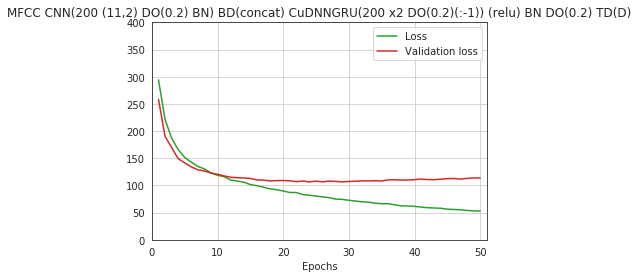

In [101]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_0, 
                       rnn_type=M.RNNType.GRU, rnn_layers=2), spectrogram=False, epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 26)          0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         57400     
_________________________________________________________________
dropout_211 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_132 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_45 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
dropout_212 (Dropout)        (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNGRU)              (None, None, 200)         361200    
__________

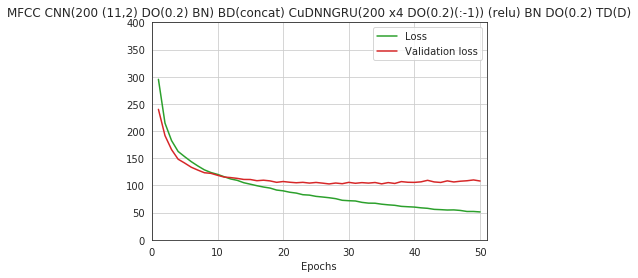

In [100]:
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_0, 
                       rnn_type=M.RNNType.GRU, rnn_layers=4), spectrogram=False, epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         354400    
_________________________________________________________________
dropout_368 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_203 (Bat (None, None, 200)         800       
_________________________________________________________________
bidirectional_78 (Bidirectio (None, None, 400)         482400    
_________________________________________________________________
dropout_369 (Dropout)        (None, None, 400)         0         
_________________________________________________________________
rnn2 (CuDNNGRU)              (None, None, 200)         361200    
__________

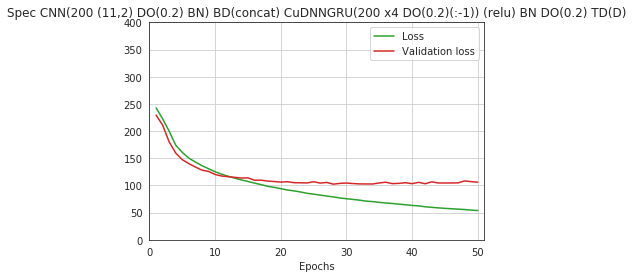

In [182]:
audio_gen=None
reload(DG)
reload(T)
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_0, 
                       rnn_type=M.RNNType.GRU, rnn_layers=4), spectrogram=True, mfcc_concat=False, epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 26)          0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         57400     
_________________________________________________________________
dropout_244 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_150 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
dropout_245 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_151 (Bat (None, None, 200)         800       
__________

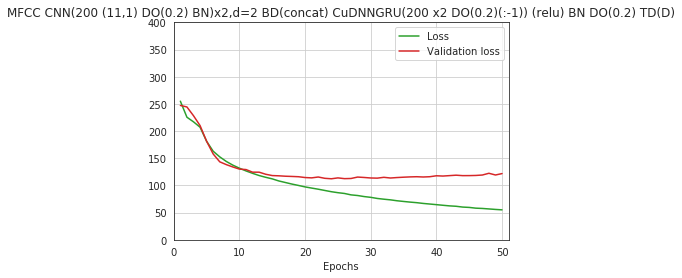

In [108]:
cnn_config_2d=M.CNNConfig(filters=200, kernel_size=11, conv_stride=1, conv_border_mode='valid', cnn_layers=2, dilation=2)
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_2d, 
                       rnn_type=M.RNNType.GRU, rnn_layers=2), spectrogram=False, epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 26)          0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         57400     
_________________________________________________________________
dropout_248 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_153 (Bat (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         440200    
_________________________________________________________________
dropout_249 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
batch_normalization_154 (Bat (None, None, 200)         800       
__________

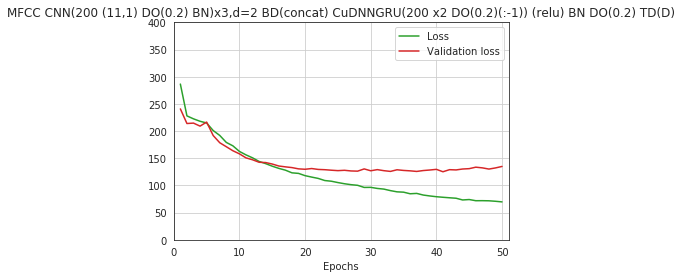

In [109]:
cnn_config_3d=M.CNNConfig(filters=200, kernel_size=11, conv_stride=1, conv_border_mode='valid', cnn_layers=3, dilation=2)
train_model(M.RNNModel(bd_merge=M.BidirectionalMerge.concat, cnn_config=cnn_config_3d, 
                       rnn_type=M.RNNType.GRU, rnn_layers=2), spectrogram=False, epochs=50)

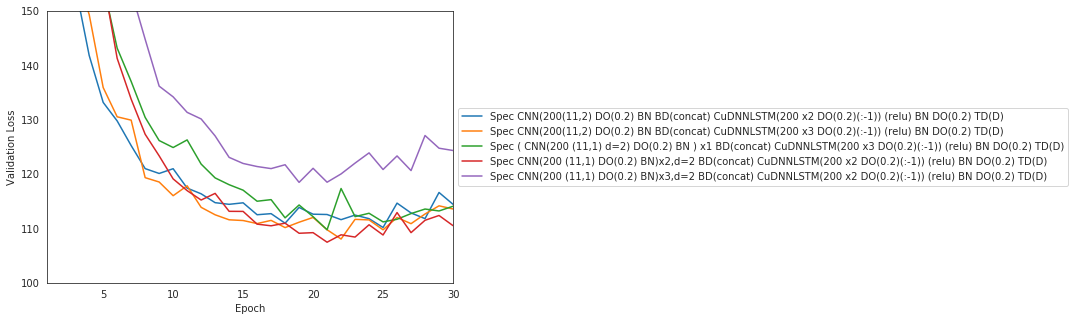

In [84]:
T.plot_comparison(
    pickles=[
        'results/Spec CNN(200(11,2) DO(0.2) BN BD(concat) CuDNNLSTM(200 x2 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle',
        'results/Spec CNN(200(11,2) DO(0.2) BN BD(concat) CuDNNLSTM(200 x3 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle', 
        'results/Spec ( CNN(200 (11,1) d=2) DO(0.2) BN ) x1 BD(concat) CuDNNLSTM(200 x3 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle', 
    'results/Spec CNN(200 (11,1) DO(0.2) BN)x2,d=2 BD(concat) CuDNNLSTM(200 x2 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle',
'results/Spec CNN(200 (11,1) DO(0.2) BN)x3,d=2 BD(concat) CuDNNLSTM(200 x2 DO(0.2)(:-1)) (relu) BN DO(0.2) TD(D).pickle'],
                  min_epoch=1, min_loss=100, max_loss=150)

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [ ]:
# specify the model
model_end = final_model()

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [ ]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [24]:
from IPython.display import Audio
def get_predictions(spectrogram, partition, index):
    audio_path = T.get_predictions(get_gen(spectrogram=spectrogram),
                        model,
                        partition=partition, index=index)
    return audio_path

In [9]:
model = T.load_model(get_gen(spectrogram=True),
                     M.RNNModel(cnn_config=M.CNNConfig(kernel_size=3, conv_stride=1, conv_border_mode="same", 
                                cnn_layers=8,
                                cnn_activation_before_bn_do=False), 
                                rnn_type=M.RNNType.GRU, rnn_layers=1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d1 (Conv1D)             (None, None, 200)         96800     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
reluC0 (Activation)          (None, None, 200)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 200)         800       
_________________________________________________________________
conv1d2 (Conv1D)             (None, None, 200)         120200    
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 200)         0         
__________

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [25]:
Audio(get_predictions(True, 'train', 0))

--------------------------------------------------------------------------------
True transcription:

a great rascal put in north
--------------------------------------------------------------------------------
Predicted transcription:

an great raskal but in north
--------------------------------------------------------------------------------


Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [26]:
Audio(get_predictions(True, 'validation', 0))

--------------------------------------------------------------------------------
True transcription:

she gathered up her reins
--------------------------------------------------------------------------------
Predicted transcription:

she gatter ap her ras
--------------------------------------------------------------------------------


One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!